# Predicting the Future of Product Sales and Crafting the Optimal Inventory Strategy



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



<h1>Introduction</h1>


<p>Dealing with the ever-shifting pattern of customer demand is a basic problem that supply chain professionals have to manage. Supply chain professionals often combine their professional judgment with some basic statistical techniques to infer the demand for products from the past. This is relatively easy to do for small product categories and stable demand patterns. But when companies grow and handle larger product categories with constantly evolving consumer demands, this traditional demand forecasting technique may not be effective.
</p>

<p>
In this notebook, we have cover a more modern and scalable alternative – a programmatic, data-driven demand forecasting methodology. We will build a demand forecasting model in Python. We will also use this model for inventory optimization concepts like reorder points, safety stock, and economic order quantity (EOQ).
</p>
<p>
Throughout this project, we will address two key business questions:
</p>
<ol>
<li>
<em>What is the demand forecast for the top-selling product in the next 24 months?</em>
</li>
<li>
<em>What is the optimal inventory level for the product?</em>
</li>
</ol>




<h1>Project Outline</h1>
<p>For this project, we have completed the following tasks:</p>

- [x] Performed Exploratory Data Analysis.
- [x] Cleaned and Prepared the data for modeling.
- [x] Conducted Time Series Modeling With Prophet.
- [x] Evaluated the model performance.
- [x] Interpret the model results and answer the business questions.


## Problem Statement
<div class="card">
  <p>Product volumes of high demand and continuously fluctuating consumer demand patterns present a scaling problem to traditional methods of demand forecasting. Something that reduces the level of guesswork and keeps unnecessary costly repercussions of poorly optimized stock in check is needed.</p>
</div>

## Project Libraries


In [3]:
#| code-fold: true
#| code-summary: "Show the code"
# import project libraries
import kagglehub
import pandas as pd
import numpy as np
import math
import seaborn as sns
import os
import sys

# data preprocessing, Model Building and Fitting, Model Evaluation and Tuning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from prophet import Prophet
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt # for plotting
# import squarify # for tree maps
!pip install squarify -qqq
import squarify

# Exploratory Data Analysis
<p>
The working <a href="https://data.mendeley.com/datasets/8gx2fvg2k6/5">dataset</a> contains entries of customer demand information The data contains 53 features (columns)
</p>
<p>
To understand the data, we will  use the following techniques:
</p>
<ul class="task-list">
<li> Data Understanding through Visuals.</li>
<li> Exploratory Data Visualizations.</li>
</ul>

In [4]:
path = kagglehub.dataset_download("shashwatwork/dataco-smart-supply-chain-for-big-data-analysis")

print("Path to dataset files:", path)

100%|██████████| 25.7M/25.7M [00:00<00:00, 74.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shashwatwork/dataco-smart-supply-chain-for-big-data-analysis/versions/1


In [5]:
file_path = "/root/.cache/kagglehub/datasets/shashwatwork/dataco-smart-supply-chain-for-big-data-analysis/versions/1/DataCoSupplyChainDataset.csv"
df = pd.read_csv( file_path, encoding="ISO-8859-1")
df.head(2)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class


In [6]:
# retrieve the number of columns and rows
df.describe()

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Department Id,Latitude,...,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Price,Product Status
count,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180516.000000,180519.000000,180519.000000,...,180519.000000,180519.000000,180519.000000,180519.000000,24840.000000,180519.000000,180519.000000,0.0,180519.000000,180519.0
mean,3.497654,2.931847,21.974989,183.107609,0.548291,31.851451,6691.379495,35921.126914,5.443460,29.719955,...,2.127638,203.772096,183.107609,21.974989,55426.132327,692.509764,31.851451,NaN,141.232550,0.0
std,1.623722,1.374449,104.433526,120.043670,0.497664,15.640064,4162.918106,37542.461122,1.629246,9.813646,...,1.453451,132.273077,120.043670,104.433526,31919.279101,336.446807,15.640064,NaN,139.732492,0.0
min,0.000000,0.000000,-4274.979980,7.490000,0.000000,2.000000,1.000000,603.000000,2.000000,-33.937553,...,1.000000,9.990000,7.490000,-4274.979980,1040.000000,19.000000,2.000000,NaN,9.990000,0.0
25%,2.000000,2.000000,7.000000,104.379997,0.000000,18.000000,3258.500000,725.000000,4.000000,18.265432,...,1.000000,119.980003,104.379997,7.000000,23464.000000,403.000000,18.000000,NaN,50.000000,0.0
50%,3.000000,4.000000,31.520000,163.990005,1.000000,29.000000,6457.000000,19380.000000,5.000000,33.144863,...,1.000000,199.919998,163.990005,31.520000,59405.000000,627.000000,29.000000,NaN,59.990002,0.0
75%,5.000000,4.000000,64.800003,247.399994,1.000000,45.000000,9779.000000,78207.000000,7.000000,39.279617,...,3.000000,299.950012,247.399994,64.800003,90008.000000,1004.000000,45.000000,NaN,199.990005,0.0
max,6.000000,4.000000,911.799988,1939.989990,1.000000,76.000000,20757.000000,99205.000000,12.000000,48.781933,...,5.000000,1999.989990,1939.989990,911.799988,99301.000000,1363.000000,76.000000,NaN,1999.989990,0.0


<details><summary>Click to see some Notable Observation of the Data</summary>
<ol type="1">
<li><p>Aproximately <code>55%</code> of orders had late delivery risks.</p></li>
<li><p>Aproximately <code>75%</code> of products cost <code>$199.99</code></p></li>
<li><p>All the products are available.</p></li>
<li><p>75% of customers bought goods worth at least <code>$247.40</code></p></li>
</ol>
<p>
Further inspection of the data will help us understand the data better.
</p>
</details>


## Data Preprocessing

<p>
we will focus on historical sales data, and product attributes like; stock level, and product category, we will also analyze the impact of other variables that contribute to demand patterns including geographic factors, customer segments and lead time.
</p>

### Preprocessing Tasks

- Drop irrelevant columns
- Drop rows with missing values
- Create new features
- Convert categorical features to numerical features

<p>Based on the above, we will drop the majority of the columns that are not relevant for forecasting the demand and extract new features from the existing columns
</p>



#### Drop Irrelevant Columns


In [7]:
#| code-fold: true
#| code-summary: "Show the code"

# drop irrelevant columns
def drop_columns(df, columns_to_drop):
    try:
        df = df.drop(columns=columns_to_drop)
        print(f"{len(columns_to_drop)} columns dropped successfully. Number of columns remaining: {len(df.columns)}")
        return df
    except KeyError as e:
        print(f"""Column(s): {e} not found in dataframe.

            No columns dropped.
            Please Check that the column names are correct.""")
        return df

# Specify the columns to keep
colums_to_keep = ['Days for shipping (real)',
                  'Days for shipment (scheduled)',
                  'Customer Country',
                  'Sales per customer',
                  'Delivery Status',
                  'Late_delivery_risk',
                  'Customer City',
                  'Customer Segment',
                  'Sales','Shipping Mode',
                  'Type', 'Product Card Id',
                  'Customer Zipcode',
                  'Product Category Id',
                  'Product Name',
                  'Product Price',
                  'Market',
                  'Product Status',
                  'shipping date (DateOrders)',]

# Specify the columns to drop
columns_to_drop = [col for col in df.columns if col not in colums_to_keep ]

df = drop_columns(df, columns_to_drop)

34 columns dropped successfully. Number of columns remaining: 19


In [8]:
df

,Type,Days for shipping (real),Days for shipment (scheduled),Sales per customer,Delivery Status,Late_delivery_risk,Customer City,Customer Country,Customer Segment,Customer Zipcode,Market,Sales,Product Card Id,Product Category Id,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,314.640015,Advance shipping,0,Caguas,Puerto Rico,Consumer,725.0,Pacific Asia,327.750000,1360,73,Smart watch,327.750000,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,311.359985,Late delivery,1,Caguas,Puerto Rico,Consumer,725.0,Pacific Asia,327.750000,1360,73,Smart watch,327.750000,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,309.720001,Shipping on time,0,San Jose,EE. UU.,Consumer,95125.0,Pacific Asia,327.750000,1360,73,Smart watch,327.750000,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,304.809998,Advance shipping,0,Los Angeles,EE. UU.,Home Office,90027.0,Pacific Asia,327.750000,1360,73,Smart watch,327.750000,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,298.250000,Advance shipping,0,Caguas,Puerto Rico,Corporate,725.0,Pacific Asia,327.750000,1360,73,Smart watch,327.750000,0,1/15/2018 11:24,Standard Class
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,CASH,4,4,399.980011,Shipping on time,0,Brooklyn,EE. UU.,Home Office,11207.0,Pacific Asia,399.980011,1004,45,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/20/2016 3:40,Standard Class
180515,DEBIT,3,2,395.980011,Late delivery,1,Bakersfield,EE. UU.,Corporate,93304.0,Pacific Asia,399.980011,1004,45,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/19/2016 1:34,Second Class
180516,TRANSFER,5,4,391.980011,Late delivery,1,Bristol,EE. UU.,Corporate,6010.0,Pacific Asia,399.980011,1004,45,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/20/2016 21:00,Standard Class
180517,PAYMENT,3,4,387.980011,Advance shipping,0,Caguas,Puerto Rico,Consumer,725.0,Pacific Asia,399.980011,1004,45,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/18/2016 20:18,Standard Class


#### Drop Rows with Missing Values

In [9]:
# drop customer Zip code.
df = df.drop(columns=['Customer Zipcode'])

##### A Quick Spot Check for Missing Values

In [10]:
### Check for Missing values
def check_null_values(df):
    null_values = df.isnull().sum()
    if null_values.sum() == 0:
        print("No null values found ✅")
    else:
        print("⚠️ Null values found in the following columns:")
        for column, null_count in null_values.iteritems():
            if null_count > 0:
                print(f"{column}: {null_count}")

# Use the function
check_null_values(df)

No null values found ✅


<p>In the code above, `df.isnull().sum()` returns a Series where the index is the column names and the values are the count of null values in each column. If the sum of these counts is 0, it means there are no null values in the DataFrame, so it prints "No null values found". Otherwise, it iterates over the Series and prints the column names and counts of null values.</p>

#### Create New Features
<p>The dataset contains a `shipping date` column which is a `DateTime` object from which we can extract `Month`, `Year`, `Day` and `Day of Week` that can be useful in our analysis.</p>

- `Month` - to capture the months per sale.
- `Year` - to capture the year per sales.
- `Day` - to capture the day per sales.
- `Day of Week` - to capture the day of the week per sales.

<p>
we need to also create a new  `Lead Time` column which is the difference between the `Days for shipment (scheduled)` and the `Days for shipping (real)`. This will help us understand the impact of lead time on demand.
</p>

In [11]:
#| code-fold: true
#| code-summary: "Show the code"

# Create month, Year, Day, and Weekday columns from Shipping Date
def extract_date_parts(df, date_column, prefix):
    try:
        df[date_column] = pd.to_datetime(df[date_column])
        df[f'{prefix} Year'] = df[date_column].dt.year
        df[f'{prefix} Month'] = df[date_column].dt.month
        df[f'{prefix} Day'] = df[date_column].dt.day
        df[f'{prefix} Weekday'] = df[date_column].dt.weekday
        # verify and notify that the columns have been created
        if f'{prefix} Year' in df.columns and f'{prefix} Month' in df.columns and f'{prefix} Day' in df.columns and f'{prefix} Weekday' in df.columns:
            print(f"✅ Success! Columns Created: {prefix} Year, {prefix} Month, {prefix} Day, and {prefix} Weekday")
            return df
        else:
            print("Error creating columns. Please check that the date column name is correct.")
    except Exception as e:
        print(f"Error creating columns: {e}")
        return df
# Add Lead Time Feature from Days for shipping (real) and Days for shipment (scheduled)
df['Lead Time'] = df['Days for shipping (real)'] - df['Days for shipment (scheduled)']

# Use the function to extract date parts
df = extract_date_parts(df, 'shipping date (DateOrders)', 'Shipping')


✅ Success! Columns Created: Shipping Year, Shipping Month, Shipping Day, and Shipping Weekday


In [12]:
# display the shape of the data frame
df.shape

(180519, 23)

In [13]:
# df.to_csv("/Users/vasupatel/Documents/Winter Quarter/Gen AI/archive/df.csv", index=False)

<p>Now we have 23 columns and 180519 entries (rows) in the dataset.</p>

### Data Encoding
<p>Categorical data is not suitable for future analysis. Machine learning algorithms, for instance, can't handle categorical customer origin values like `UK`, `USA`, `France`, etc. We'll convert these categorical values into numerical values using `LabelEncoder` from the `sklearn` library.</p>

<p>we will also perform a one-hot encoding technique on categorical features for future machine learning modeling tasks.</p>


In [14]:
#| code-fold: true
#| code-summary: "Show the code"
# Select top selling product
top_product = df['Product Card Id'].value_counts().index[0]
# get top product ID
print(f"Filtering and Encoding Dataset for Top Product ID: {top_product}")

from sklearn.preprocessing import LabelEncoder

def prepare_data(df, product_card_id, categorical_cols, columns_to_drop):
    """
    Prepare a DataFrame for bivariate analysis and machine learnin
    g by applying label encoding and one-hot encoding to categorical
    columns and dropping specified columns.

    Parameters:
    df (pandas.DataFrame): The original DataFrame.
    product_card_id (int): The product card ID to filter the DataFrame on.
    categorical_cols (list of str): The names of the categorical columns to apply encoding to.
    columns_to_drop (list of str): The names of the columns to drop from the DataFrame.

    Returns:
    pandas.DataFrame: The label encoded DataFrame for bivariate analysis.
    pandas.DataFrame: The one-hot encoded DataFrame for machine learning.
    """
    try:
        df_copy = df[df['Product Card Id'] == product_card_id].copy()  # create a copy

        # label encoding
        label_encoder = LabelEncoder()
        df_label_encoded = df_copy.copy()

        # Apply label encoding to categorical variables in place
        for col in categorical_cols:
            df_label_encoded[col] = label_encoder.fit_transform(df_label_encoded[col])

        # Drop specified columns
        df_label_encoded = df_label_encoded.drop(columns=columns_to_drop)

        # one-hot encoding
        df_one_hot_encoded = pd.get_dummies(df_copy, columns=categorical_cols)

        # Drop specified columns
        df_one_hot_encoded = df_one_hot_encoded.drop(columns=columns_to_drop)
        print("Data Encoding successful. ✅")
        return  df_one_hot_encoded, df_label_encoded
    except Exception as e:
        print(f"Error preparing data: {e}")
        return None, None

# Use the function to prepare the data for bivariate analysis
categorical_cols = ['Type', 'Customer Segment',
                    'Delivery Status',
                    'Customer City',
                    'Market',
                    'Shipping Mode']

columns_to_drop = ['Product Name',
                   'Days for shipment (scheduled)',
                   'Sales per customer',
                   'Days for shipping (real)',
                   'Customer Country',
                   'shipping date (DateOrders)',
                   'Product Card Id',
                   'Product Category Id',
                   'Product Status',
                   'Product Price']

# drop columns and encode data for correlation martrix and Machine learning
onehot_encode_df, label_encode_df = prepare_data(df, top_product, categorical_cols, columns_to_drop)

# rename Type column to Payment Type
label_encode_df = label_encode_df.rename(columns={'Type': 'Payment Type'})
onehot_encode_df = onehot_encode_df.rename(columns={'Type': 'Payment Type'})

Filtering and Encoding Dataset for Top Product ID: 365
Data Encoding successful. ✅


#### Confirm Encoding of Dataset

In [15]:
label_encode_df.dtypes

,0
Payment Type,int64
Delivery Status,int64
Late_delivery_risk,int64
Customer City,int64
Customer Segment,int64
Market,int64
Sales,float64
Shipping Mode,int64
Lead Time,int64
Shipping Year,int32


In [16]:
# validate the one-hot encoding
onehot_encode_df.dtypes

,0
Late_delivery_risk,int64
Sales,float64
Lead Time,int64
Shipping Year,int32
Shipping Month,int32
...,...
Market_USCA,bool
Shipping Mode_First Class,bool
Shipping Mode_Same Day,bool
Shipping Mode_Second Class,bool


## Exploratory Data Visualizations
<p>To highlight the distributions of the individual variables as well as the relationship between the variables and the target variables, we used the following techniques:</p>

- Univariate Analysis
- Exploratory Time Series Analysis

### Univariate Analysis


#### Visualizing the Distribution of the Dataset

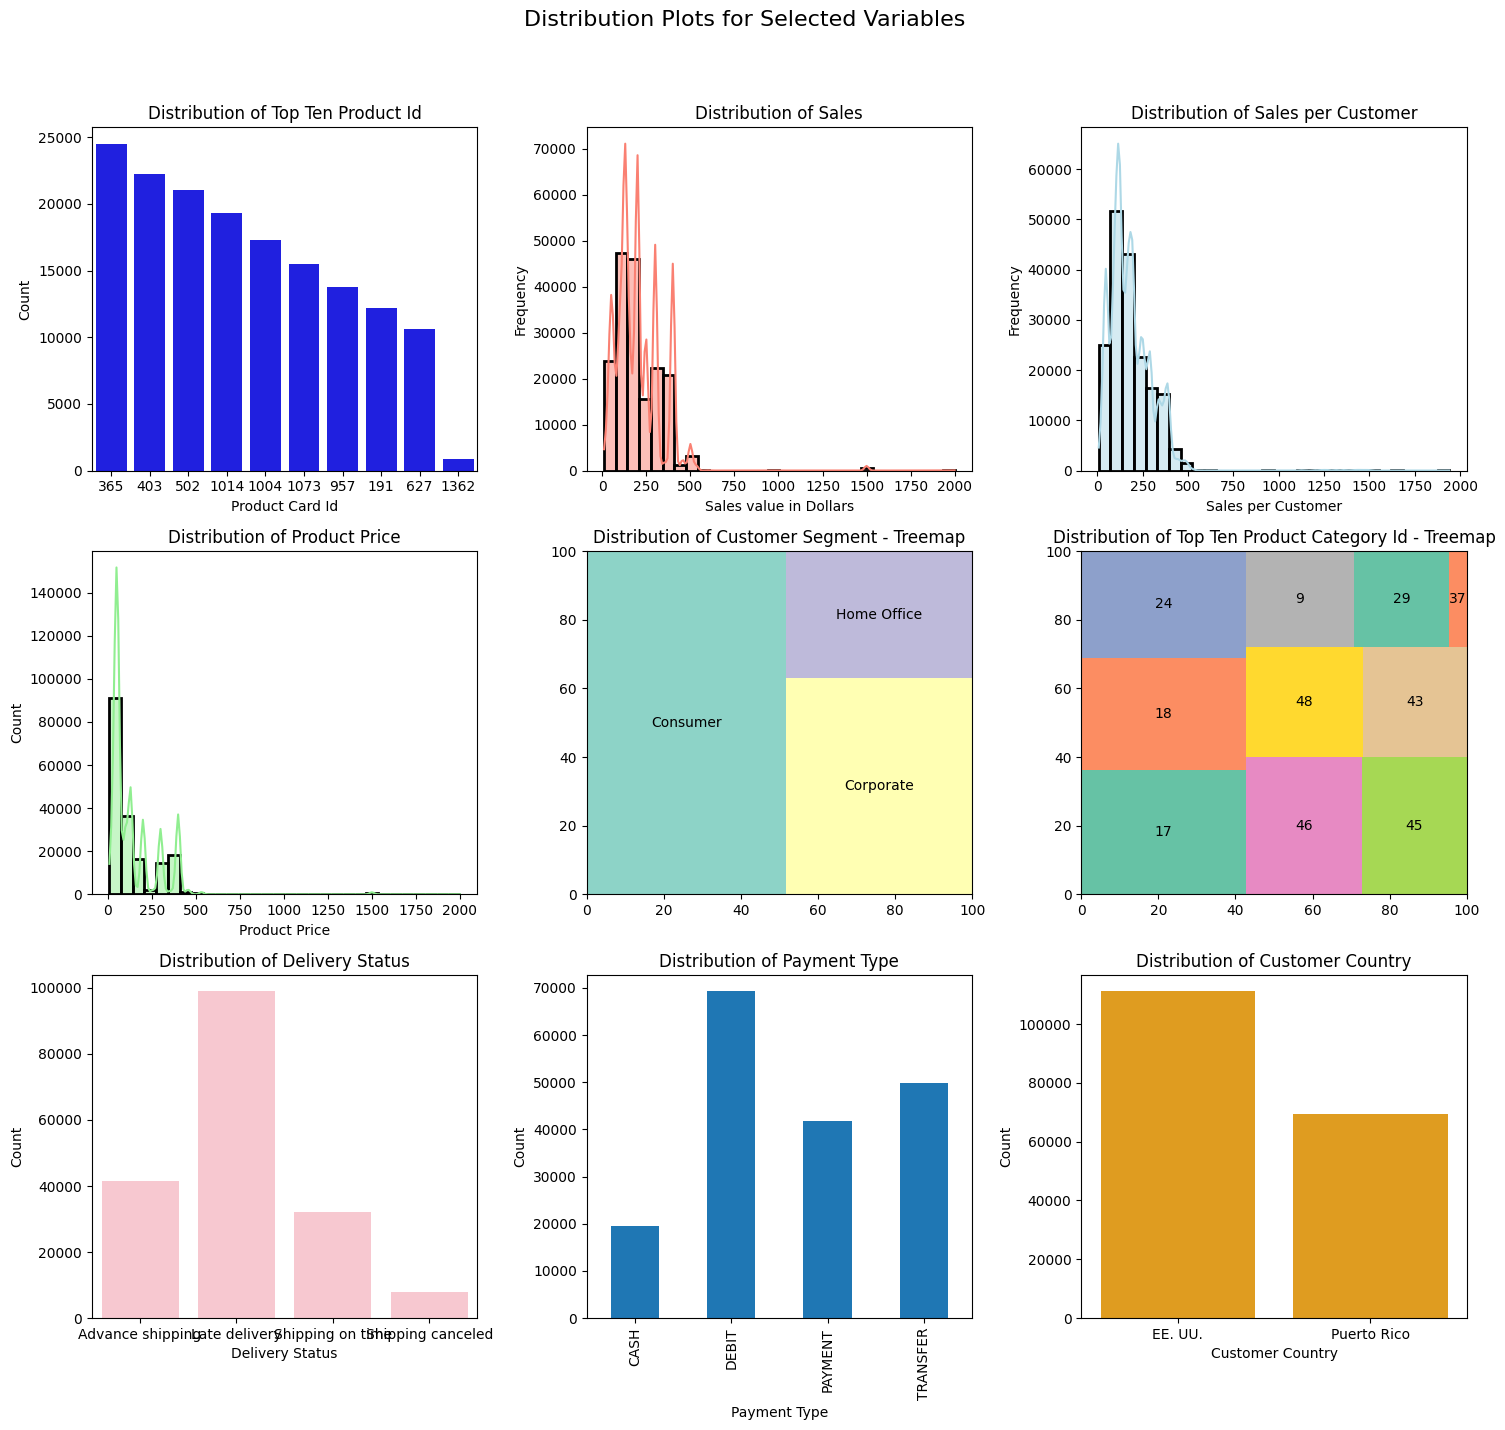

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.suptitle('Distribution Plots for Selected Variables',
             fontsize=16)
# Create a copy of the DataFrame
df_copy = df.copy()


# Plotting  the top ten products per Product Card Id
sns.countplot(data=df_copy, x='Product Card Id',
                color='blue', ax=axes[0, 0],
                order=df_copy['Product Card Id'].value_counts().iloc[:10].index)
axes[0, 0].set_title('Distribution of Top Ten Product Id')
axes[0, 0].set_xlabel('Product Card Id')
axes[0, 0].set_ylabel('Count')


# Plotting Value of sales in  dollars
sns.histplot(data=df_copy, x='Sales',
             kde=True, color='salmon',
             bins=30, linewidth=2,
             ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Sales')
axes[0, 1].set_xlabel('Sales value in Dollars')
axes[0, 1].set_ylabel('Frequency')


# Plotting Sales Value per customer
sns.histplot(data=df_copy, x='Sales per customer',
             bins=30, kde=True, linewidth=2,
             color='lightblue', ax=axes[0, 2])
axes[0, 2].set_title('Distribution of Sales per Customer')
axes[0, 2].set_xlabel('Sales per Customer')
axes[0, 2].set_ylabel('Frequency')

# Ploting the distribution of Product Price
sns.histplot(data=df_copy, x='Product Price', bins=30, kde=True,
             color='lightgreen', linewidth=2, ax=axes[1, 0])

axes[1, 0].set_title('Distribution of Product Price')
axes[1, 0].set_xlabel('Product Price')

# ploting a tree map for Customer Segment
squarify.plot(sizes=df_copy['Customer Segment'].value_counts(),
              label=df_copy['Customer Segment'].value_counts().index,
              color=sns.color_palette("Set3"), ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Customer Segment - Treemap')

# ploting a tree map for Top Ten Product Category Id
squarify.plot(sizes=df_copy['Product Category Id'].value_counts().iloc[:10],
                label=df_copy['Product Category Id'].value_counts().iloc[:10].index,
                color=sns.color_palette("Set2"), ax=axes[1, 2])
axes[1, 2].set_title('Distribution of Top Ten Product Category Id - Treemap')

# Plotting the distribution of Delivery Status
sns.countplot(data=df_copy, x='Delivery Status',
                color='pink', ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Delivery Status')
axes[2, 0].set_xlabel('Delivery Status')
axes[2, 0].set_ylabel('Count')


# Plotting the distribution Payment Type with stacked bar chart
df_copy.groupby(['Type'])['Type'].count().plot(kind='bar',
                                               stacked=True,
                                               ax=axes[2, 1])

axes[2, 1].set_title('Distribution of Payment Type')
axes[2, 1].set_xlabel('Payment Type')
axes[2, 1].set_ylabel('Count')

# Plotting the Distribution of top ten Customer Country
sns.countplot(data=df_copy, x='Customer Country',
                color='orange', ax=axes[2, 2],
                order=df_copy['Customer Country'].value_counts().iloc[:10].index)
axes[2, 2].set_title('Distribution of Customer Country')
axes[2, 2].set_xlabel('Customer Country')
axes[2, 2].set_ylabel('Count')



# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Show the plots
plt.show()


<details>
<summary>
Click to Read My Observations!
</summary>
<p>
The Top Selling <code>Product ID</code> is <code>365</code> which corresponds to a <code>product name</code>: <code>Perfect Fitness Perfect Rip Deck</code> this indicates a fast-moving product. I will focus the demand forecasting process on this product going forward
</p>
<p>
The distribution of <code>Sales Value</code> and <code>Sales per customer</code> are both positively skewed with a long tail. This indicates that the majority of sales are for low-value products. This is an interesting insight because it may suggest that the majority of customers are price-sensitive.
</p>
<p>
The distribution of <code>Product Price</code> is also positively skewed with a long tail. This means that the majority of products are low-value products.
</p>
<p>
The distribution of <code>Customer Segment</code> indicates that the majority of customers are from the consumer segment.
</p>
</details>



**NOTE**: Based on the insight from the univariate analysis, The rest of the analysis and forecasting will focus on the top-selling `Product Card Id` (365 ‘Perfect Fitness Perfect Rip Deck’)




## Exploratory Time Series Visualisation
<p>To understand the demand patterns of the top-selling product, let's create a time series heatmap to visualize the demand patterns of the top-selling product over time.</p>

### Time Series HeatMap of The Demand

<ipython-input-18-ee941f145bcb>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_df = df_heatmap.resample('M').sum()  # Resample to yearly frequency


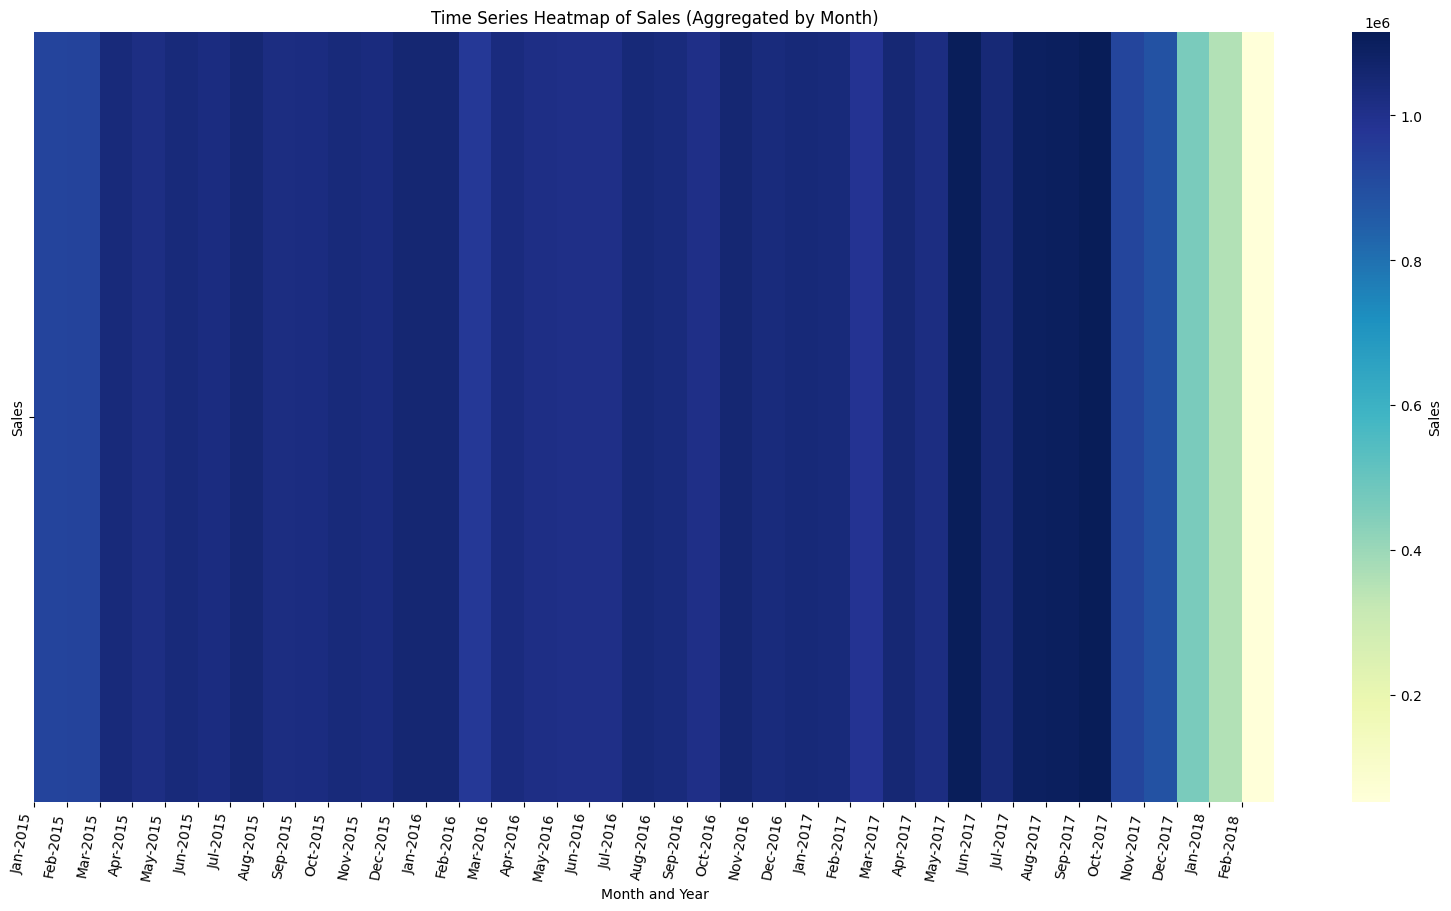

In [18]:
#| code-fold: true
#| code-summary: "Show the code"
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

# Extract shipping date (DateOrders) and Sales columns
df_heatmap = df[['shipping date (DateOrders)', 'Sales']]
# Assuming 'df' is your original dataframe

df_heatmap.set_index('shipping date (DateOrders)', inplace=True)
resampled_df = df_heatmap.resample('M').sum()  # Resample to yearly frequency
# Set x-axis ticks to represent months and years
month_labels = [calendar.month_abbr[m.month] + '-' + str(m.year) for m in resampled_df.index]
# Plot the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(resampled_df.T, cmap='YlGnBu', cbar_kws={'label': 'Sales'})
plt.xticks(ticks=range(len(month_labels)), labels=month_labels, rotation=80, ha='right')

plt.title('Time Series Heatmap of Sales (Aggregated by Month)')
plt.xlabel('Month and Year')


plt.show()

<p>Judging from consistency in the shades of the heatmap, we can see that the demand for the top-selling product is fairly stable over time. However, it is interesting to note that the number of sales recorded for the first quarters of <code>2015</code>, <code>2016</code> and <code>2017</code> remained consistent however in 2018 the number of sales recorded in the first quarter dipped significantly. This is an interesting insight that we can explore further.
</p>
<p>
Next, Let's use the <code>Prophet</code> library to model the demand for the top-selling product. This will help us understand the cyclical patterns in the demand for the top-selling product
</p>



<h1>
Forecasting Demand with Prophet
</h1>
<p>
Prophet is a forecasting tool developed by Facebook. It is designed for analyzing time series data that display patterns on different time scales such as yearly, weekly, and daily. It also has advanced capabilities for modeling the effects of holidays on a time series and implementing custom seasonalities. see the documentation <a href="https://facebook.github.io/prophet/docs/quick_start.html">here</a>
</p>

In [20]:
import pandas as pd
from prophet import Prophet
import holidays

# Prepare your DataFrame
prophet_df = df.copy()
prophet_df = prophet_df.rename(columns={'shipping date (DateOrders)': 'ds', 'Sales': 'y'})

# Generate Puerto Rican holidays
pr_holidays = holidays.PuertoRico(years=range(prophet_df['ds'].dt.year.min(), prophet_df['ds'].dt.year.max() + 1))
holidays_df = pd.DataFrame(list(pr_holidays.items()), columns=['ds', 'holiday'])

# Create a Prophet instance with the holidays DataFrame
prophet = Prophet(holidays=holidays_df)

# Fit the model
prophet.fit(prophet_df)

# Create a DataFrame with future dates for forecasting
future = prophet.make_future_dataframe(periods=365, freq='D')

# Generate forecasts
forecast = prophet.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/d785dfvb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/uk2c6z6e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8090', 'data', 'file=/tmp/tmp6ypvaptb/d785dfvb.json', 'init=/tmp/tmp6ypvaptb/uk2c6z6e.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model0l6o6zsl/prophet_model-20250226002301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:23:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:27:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<h3>Evaluating the Accuracy of the Time Series Forecast</h3>

<p>To determine the accuracy of the prophet model, we will use the `cross_validationa()` function provided by `Prophet`</p>

In [21]:
from prophet.diagnostics import cross_validation, performance_metrics
# Perform cross-validation
df_cv = cross_validation(model=prophet, initial='730 days', period='365 days', horizon='365 days')

INFO:prophet:Making 1 forecasts with cutoffs between 2017-02-06 22:14:00 and 2017-02-06 22:14:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/it6b43_f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/dfgp7c19.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9563', 'data', 'file=/tmp/tmp6ypvaptb/it6b43_f.json', 'init=/tmp/tmp6ypvaptb/dfgp7c19.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelxv6xig2k/prophet_model-20250226002807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:28:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:28:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


/usr/local/lib/python3.11/dist-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


<Figure size 900x600 with 0 Axes>

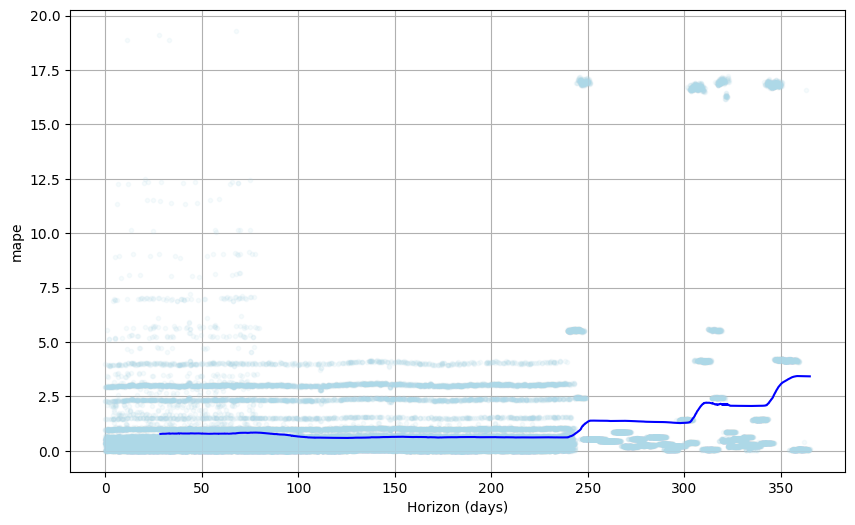

In [22]:
# Plot MAPE
from prophet.plot import plot_cross_validation_metric
#  set fig size
plt.figure(figsize=(9, 6))
fig = plot_cross_validation_metric(df_cv, metric='mape')
fig.get_axes()[0].get_lines()[0].set_markerfacecolor('#ADD8E7')  # Change color of the dots
fig.get_axes()[0].get_lines()[0].set_markeredgecolor('#ADD8E7')  # Change color of the dot edges

In [23]:
#| code-fold: true
#| code-summary: "Show the code"
from sklearn.model_selection import ParameterGrid

# Assuming prophet_df is your DataFrame with 'ds' and 'y' columns
prophet_df = df.copy()
prophet_df = prophet_df.rename(columns={'shipping date (DateOrders)': 'ds', 'Sales': 'y'})

# Specify hyperparameter values to try
param_grid = {
    'seasonality_mode': ["additive", 'multiplicative'],
    'seasonality_prior_scale': [1, 5, 10, 20],
    'holidays_prior_scale': [5, 10, 20, 25],
    'changepoint_prior_scale': [0.005, 0.01, 0.05, 0.1]
}

# Generate all combinations of hyperparameters using ParameterGrid
param_combinations = ParameterGrid(param_grid)

In [24]:
#| code-fold: true
#| code-summary: "Show the code"
from itertools import product
# Store results in a dictionary
results = {}
print(f"trying all {len(param_combinations)} hyperparameter combinations")
# Generate all combinations of hyperparameters
param_combinations = list(product(*param_grid.values()))

for params in param_combinations:
    # Create a Prophet instance with current hyperparameter values
    prophet = Prophet(**dict(zip(param_grid.keys(), params)))

    # Fit the model
    prophet.fit(prophet_df)

    # Perform cross-validation
    df_cv = cross_validation(model=prophet, initial='730 days', period='365 days', horizon='365 days')


    # Calculate performance metrics
    df_metrics = performance_metrics(df_cv, rolling_window=0)

    # Store metrics in the results dictionary
    results[params] = df_metrics['mape'].mean()


trying all 128 hyperparameter combinations


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/geljwygk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/lm2uczn3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39252', 'data', 'file=/tmp/tmp6ypvaptb/geljwygk.json', 'init=/tmp/tmp6ypvaptb/lm2uczn3.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modela_kenwyk/prophet_model-20250226002923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:29:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:30:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2017-02-06 22:14:00 and 2017-02-06 22:14:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ubaahqg0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/hpf7udho.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49730', 'data', 'file=/tmp/tmp6ypvaptb/ubaahqg0.json', 'init=/tmp/tmp6ypvaptb/hpf7udho.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelg9j_p8y_/prophet_model-20250226003102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:31:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:31:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/y9fmz79f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/pdd5law2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/lco1ux6t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/o4ip0k6q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83428', 'data', 'file=/tmp/tmp6ypvaptb/lco1ux6t.json', 'init=/tmp/tmp6ypvaptb/o4ip0k6q.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model06gotv26/prophet_model-20250226003423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:34:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:34:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/zgulzw44.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/_gp0k00_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/b_mpiy3t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/09m1uxd6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14756', 'data', 'file=/tmp/tmp6ypvaptb/b_mpiy3t.json', 'init=/tmp/tmp6ypvaptb/09m1uxd6.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modeleqg0lce3/prophet_model-20250226003800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:38:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:38:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/f5spx8c0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/_m9k8zsw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/yz4nfspr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/vddbjqzp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63862', 'data', 'file=/tmp/tmp6ypvaptb/yz4nfspr.json', 'init=/tmp/tmp6ypvaptb/vddbjqzp.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelatq5cy_e/prophet_model-20250226004247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:42:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:43:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/s9gyh0q5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ts41mn6z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ydw28zas.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/pbyc0drt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=725', 'data', 'file=/tmp/tmp6ypvaptb/ydw28zas.json', 'init=/tmp/tmp6ypvaptb/pbyc0drt.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modeltligaxln/prophet_model-20250226004528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:45:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:45:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/grjkdihu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/f38zx76e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/dj0ij_zp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/aow3ijy4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55195', 'data', 'file=/tmp/tmp6ypvaptb/dj0ij_zp.json', 'init=/tmp/tmp6ypvaptb/aow3ijy4.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelhajcztzg/prophet_model-20250226004850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:48:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:49:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ykidbic_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/10ktkr41.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/djxf20rk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/0byuljiu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44381', 'data', 'file=/tmp/tmp6ypvaptb/djxf20rk.json', 'init=/tmp/tmp6ypvaptb/0byuljiu.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modeli32kij0k/prophet_model-20250226005227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:52:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:52:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/t8ibfkat.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/n7s6ncd2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/l9qty817.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/8qcr_scu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33006', 'data', 'file=/tmp/tmp6ypvaptb/l9qty817.json', 'init=/tmp/tmp6ypvaptb/8qcr_scu.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelbl7m0sew/prophet_model-20250226005717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:57:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:57:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/3lnq8ara.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/000aw8q6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/1_p1695s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/klyozfit.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51489', 'data', 'file=/tmp/tmp6ypvaptb/1_p1695s.json', 'init=/tmp/tmp6ypvaptb/klyozfit.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelrzk4xo04/prophet_model-20250226005955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:59:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:00:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/0icwrako.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/lfv4khgl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/lj0lcqmb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/k4ythr7j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2916', 'data', 'file=/tmp/tmp6ypvaptb/lj0lcqmb.json', 'init=/tmp/tmp6ypvaptb/k4ythr7j.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modeloq7gtynn/prophet_model-20250226010315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:03:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:03:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/pguu880q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/v843qrlt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/d2icvgih.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/p4b9oren.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11782', 'data', 'file=/tmp/tmp6ypvaptb/d2icvgih.json', 'init=/tmp/tmp6ypvaptb/p4b9oren.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelpb_ozvig/prophet_model-20250226010648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:06:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:07:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/cd8ahuib.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/dk748q93.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/wi9gdcts.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/g5ngsxfq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4976', 'data', 'file=/tmp/tmp6ypvaptb/wi9gdcts.json', 'init=/tmp/tmp6ypvaptb/g5ngsxfq.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelj74ndwpv/prophet_model-20250226011132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:11:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:12:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/_zqjrs1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/me2zq2sy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ef3kn_f5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/35fniv72.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72019', 'data', 'file=/tmp/tmp6ypvaptb/ef3kn_f5.json', 'init=/tmp/tmp6ypvaptb/35fniv72.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelz8264yw9/prophet_model-20250226011409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:14:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:14:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/wk4abl1e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/7pwyj4fv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/wj_eujhp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/6keflzzy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33116', 'data', 'file=/tmp/tmp6ypvaptb/wj_eujhp.json', 'init=/tmp/tmp6ypvaptb/6keflzzy.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelrd8wr52j/prophet_model-20250226011729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:17:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:18:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/2h2slxt4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/y9h3rig9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/kdawn6vx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/0jnhp208.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3952', 'data', 'file=/tmp/tmp6ypvaptb/kdawn6vx.json', 'init=/tmp/tmp6ypvaptb/0jnhp208.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model3v_kq6n4/prophet_model-20250226012103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:21:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:21:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/4hsaup09.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/498yo29_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/uxumwbp3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/tnwjlu01.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52105', 'data', 'file=/tmp/tmp6ypvaptb/uxumwbp3.json', 'init=/tmp/tmp6ypvaptb/tnwjlu01.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelq6p4s3os/prophet_model-20250226012554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:25:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:26:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ynyo45ed.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/cwli0wwd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/r4f6s1i_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/xg_fzwds.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86658', 'data', 'file=/tmp/tmp6ypvaptb/r4f6s1i_.json', 'init=/tmp/tmp6ypvaptb/xg_fzwds.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model2fvjxxix/prophet_model-20250226012851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:28:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:29:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/z36ln75b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/y59zt9f3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/z6fpyk9a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/3thobisa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60315', 'data', 'file=/tmp/tmp6ypvaptb/z6fpyk9a.json', 'init=/tmp/tmp6ypvaptb/3thobisa.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modeluqu8csx1/prophet_model-20250226013123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/allho033.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/rj656o3k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/osidmmh6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/yeh0m79r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25080', 'data', 'file=/tmp/tmp6ypvaptb/osidmmh6.json', 'init=/tmp/tmp6ypvaptb/yeh0m79r.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelw7oq07zt/prophet_model-20250226013728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/b6f_7yf4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/pkgglxbn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/6l7ubngf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/3miygwsc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13623', 'data', 'file=/tmp/tmp6ypvaptb/6l7ubngf.json', 'init=/tmp/tmp6ypvaptb/3miygwsc.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelrbhq4nxu/prophet_model-20250226014203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:42:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/24461ycy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/1autm9oa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/xjtrdgt9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/y93dtuag.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20363', 'data', 'file=/tmp/tmp6ypvaptb/xjtrdgt9.json', 'init=/tmp/tmp6ypvaptb/y93dtuag.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelcxz39cab/prophet_model-20250226014501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/gdzea87w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/p0nk7nrc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/9la1m5g9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/lp4weepb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88959', 'data', 'file=/tmp/tmp6ypvaptb/9la1m5g9.json', 'init=/tmp/tmp6ypvaptb/lp4weepb.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model95vucbfr/prophet_model-20250226014739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/bwpd0n5i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/i_p5v92c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/pa1ufouh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/r9_ak0o0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1685', 'data', 'file=/tmp/tmp6ypvaptb/pa1ufouh.json', 'init=/tmp/tmp6ypvaptb/r9_ak0o0.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modeldv5l1kr0/prophet_model-20250226015338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:54:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/djsmup9u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/tbudkyof.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/s286_jhi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/j2l2xngp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60894', 'data', 'file=/tmp/tmp6ypvaptb/s286_jhi.json', 'init=/tmp/tmp6ypvaptb/j2l2xngp.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelpwqykn59/prophet_model-20250226015811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:58:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:58:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ajo6j6lj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/s_ql10h7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/zfp5vkgl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/qgvyd1p3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73731', 'data', 'file=/tmp/tmp6ypvaptb/zfp5vkgl.json', 'init=/tmp/tmp6ypvaptb/qgvyd1p3.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelhk40edzs/prophet_model-20250226020109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:01:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:01:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/96ysjqqc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ptskfjub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/uifugfyf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/wpwzz7mn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52804', 'data', 'file=/tmp/tmp6ypvaptb/uifugfyf.json', 'init=/tmp/tmp6ypvaptb/wpwzz7mn.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelp_xbzp1l/prophet_model-20250226020345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:03:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:04:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/k_my54d0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/pej7m_1s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/s4uit0ye.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/m_r9t_i9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83989', 'data', 'file=/tmp/tmp6ypvaptb/s4uit0ye.json', 'init=/tmp/tmp6ypvaptb/m_r9t_i9.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelmqbh6500/prophet_model-20250226021002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:10:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:10:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/c9srl07j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/nu11r0qy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/b_o_t3jk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/lmv1gh35.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54797', 'data', 'file=/tmp/tmp6ypvaptb/b_o_t3jk.json', 'init=/tmp/tmp6ypvaptb/lmv1gh35.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model9xt_ab0n/prophet_model-20250226021439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:14:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:15:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ciy5003o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/wpp655s1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/lvfzsoyr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/v4of37nk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53612', 'data', 'file=/tmp/tmp6ypvaptb/lvfzsoyr.json', 'init=/tmp/tmp6ypvaptb/v4of37nk.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modeldxcc_zfv/prophet_model-20250226021737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:17:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:17:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/s76nz_zt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/62lcf2t9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/4wxazsz8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/tzo5b4cq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81024', 'data', 'file=/tmp/tmp6ypvaptb/4wxazsz8.json', 'init=/tmp/tmp6ypvaptb/tzo5b4cq.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model0aje1jqe/prophet_model-20250226022013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:20:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:20:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/0m229v5y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/xc2qjasj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ulorwsor.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/o9urw8tn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21518', 'data', 'file=/tmp/tmp6ypvaptb/ulorwsor.json', 'init=/tmp/tmp6ypvaptb/o9urw8tn.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelc07i_y97/prophet_model-20250226022617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:26:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:26:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/f20aeyj6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/bjnuzo29.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/0x7p3t2b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/yu4yp8iw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99194', 'data', 'file=/tmp/tmp6ypvaptb/0x7p3t2b.json', 'init=/tmp/tmp6ypvaptb/yu4yp8iw.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelfip90myx/prophet_model-20250226023102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:31:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:31:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/d0488men.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/m51lmdb9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/9vp_cn70.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/yao1kzl5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82425', 'data', 'file=/tmp/tmp6ypvaptb/9vp_cn70.json', 'init=/tmp/tmp6ypvaptb/yao1kzl5.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model5q1cokyf/prophet_model-20250226023348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:33:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:34:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/smiqd1dp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/okgc0_1x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ywvimcni.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/sle0ga76.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92999', 'data', 'file=/tmp/tmp6ypvaptb/ywvimcni.json', 'init=/tmp/tmp6ypvaptb/sle0ga76.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelozdqz66s/prophet_model-20250226023645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:36:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:37:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/g673tlsc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/298hk5ey.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/1i_rg7_8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/q7q83n1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28647', 'data', 'file=/tmp/tmp6ypvaptb/1i_rg7_8.json', 'init=/tmp/tmp6ypvaptb/q7q83n1k.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modele70uqzeg/prophet_model-20250226024229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:42:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:42:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/36arjsp4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/fy9so8jl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/1fv44bty.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/gvh9iuo8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92456', 'data', 'file=/tmp/tmp6ypvaptb/1fv44bty.json', 'init=/tmp/tmp6ypvaptb/gvh9iuo8.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model_0_gzzt5/prophet_model-20250226024734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:47:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:47:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/fdffd5cd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/3l_m6kta.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/vywsag9z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/s3qa88_e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77603', 'data', 'file=/tmp/tmp6ypvaptb/vywsag9z.json', 'init=/tmp/tmp6ypvaptb/s3qa88_e.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model9vz8rrpj/prophet_model-20250226025017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:50:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:50:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/5vytoa5m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/3iv8ztjf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/i0frv9yr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/gzr8mhsi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30222', 'data', 'file=/tmp/tmp6ypvaptb/i0frv9yr.json', 'init=/tmp/tmp6ypvaptb/gzr8mhsi.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model10f4b41j/prophet_model-20250226025315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:53:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:53:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/64dlnmns.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/1h0hn__g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/nspq3ulr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/yynjwq7g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94393', 'data', 'file=/tmp/tmp6ypvaptb/nspq3ulr.json', 'init=/tmp/tmp6ypvaptb/yynjwq7g.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelltw5yd1u/prophet_model-20250226025902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:59:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:59:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/iogtmwfy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/hjlvxj2s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/z07hdjel.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/le605qrd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29866', 'data', 'file=/tmp/tmp6ypvaptb/z07hdjel.json', 'init=/tmp/tmp6ypvaptb/le605qrd.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelis4dlg3r/prophet_model-20250226030413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:04:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:04:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/n8qr0jra.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/1t621125.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/co7py5a8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/k59634pp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17553', 'data', 'file=/tmp/tmp6ypvaptb/co7py5a8.json', 'init=/tmp/tmp6ypvaptb/k59634pp.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelndpp1h7q/prophet_model-20250226030648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:06:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:07:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/fyrvguxa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/d6d_696u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/l1pjusc_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/thpsk0ef.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35805', 'data', 'file=/tmp/tmp6ypvaptb/l1pjusc_.json', 'init=/tmp/tmp6ypvaptb/thpsk0ef.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelzwkypsmf/prophet_model-20250226030956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:09:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:10:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/xesf33yb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/cfjev059.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/p5gav2ly.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/1p1hc_oc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62220', 'data', 'file=/tmp/tmp6ypvaptb/p5gav2ly.json', 'init=/tmp/tmp6ypvaptb/1p1hc_oc.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model0_yz_3f6/prophet_model-20250226031613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:16:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:16:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/gi394b3n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/7j849xtu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/5tyiz84z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/gbjhexsd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26612', 'data', 'file=/tmp/tmp6ypvaptb/5tyiz84z.json', 'init=/tmp/tmp6ypvaptb/gbjhexsd.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelyj4h8a2f/prophet_model-20250226032134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:21:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:22:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/fyrfws2b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/rlk7t_oi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/wfcp2dvm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/89au06co.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28197', 'data', 'file=/tmp/tmp6ypvaptb/wfcp2dvm.json', 'init=/tmp/tmp6ypvaptb/89au06co.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model7m844osz/prophet_model-20250226032418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:24:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:24:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/vzu6_sup.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/mbyt6mxe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/mcpfb228.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/vd685ts0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3430', 'data', 'file=/tmp/tmp6ypvaptb/mcpfb228.json', 'init=/tmp/tmp6ypvaptb/vd685ts0.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelq0cp4oe5/prophet_model-20250226032719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:27:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:27:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/kkot_csa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/naj46mgl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/c9_af0v_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/6w4gnw58.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25527', 'data', 'file=/tmp/tmp6ypvaptb/c9_af0v_.json', 'init=/tmp/tmp6ypvaptb/6w4gnw58.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modeln_jvnjuq/prophet_model-20250226033316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:33:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:33:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/8jpsbs1y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/e1vb0gdy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/6naw7xec.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/7ojsx3h3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42917', 'data', 'file=/tmp/tmp6ypvaptb/6naw7xec.json', 'init=/tmp/tmp6ypvaptb/7ojsx3h3.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modellu1b5yqx/prophet_model-20250226033832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:38:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:38:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/t5sxdjhy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/2l44migv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/x586menz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/uxwh9rby.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2257', 'data', 'file=/tmp/tmp6ypvaptb/x586menz.json', 'init=/tmp/tmp6ypvaptb/uxwh9rby.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelbmfh62gn/prophet_model-20250226034054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:40:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:41:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ipc9d31q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/b9ff1z2_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/3owm9pd1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/jomhku_e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21478', 'data', 'file=/tmp/tmp6ypvaptb/3owm9pd1.json', 'init=/tmp/tmp6ypvaptb/jomhku_e.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modellfehx44l/prophet_model-20250226034407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:44:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:44:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/3hw2tb1w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/scdn4c0p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ee4cpu0u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/eugzzc2m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44389', 'data', 'file=/tmp/tmp6ypvaptb/ee4cpu0u.json', 'init=/tmp/tmp6ypvaptb/eugzzc2m.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelbha0z_1f/prophet_model-20250226034831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:48:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:49:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/xcb7mbl2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/l95ttcri.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/l0f6w3q3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/i8x24kk9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96094', 'data', 'file=/tmp/tmp6ypvaptb/l0f6w3q3.json', 'init=/tmp/tmp6ypvaptb/i8x24kk9.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model60j49bny/prophet_model-20250226035450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:54:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:55:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/cfytagj7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/cwgaxloq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/u_r153kn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/hppmj3xv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52915', 'data', 'file=/tmp/tmp6ypvaptb/u_r153kn.json', 'init=/tmp/tmp6ypvaptb/hppmj3xv.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model08qxap11/prophet_model-20250226035722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/nd416yv4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/pdzmfx82.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/7u0_rcko.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/e7ru1lav.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35403', 'data', 'file=/tmp/tmp6ypvaptb/7u0_rcko.json', 'init=/tmp/tmp6ypvaptb/e7ru1lav.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelwjlsmuyo/prophet_model-20250226040054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:00:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:01:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/hz3zbfpx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/x21lhhtp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/0n9v1ny3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/e0whuas8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9310', 'data', 'file=/tmp/tmp6ypvaptb/0n9v1ny3.json', 'init=/tmp/tmp6ypvaptb/e0whuas8.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model85s0f3uk/prophet_model-20250226040537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:05:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:06:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/1iipcsr9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/x8ldbbfg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/55dtho7f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/a9h0ciig.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90037', 'data', 'file=/tmp/tmp6ypvaptb/55dtho7f.json', 'init=/tmp/tmp6ypvaptb/a9h0ciig.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelfkejwq9c/prophet_model-20250226041140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:11:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:12:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/vwwhwgb5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/fgdu6etu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/vy2xiuft.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/21ve2n3b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13991', 'data', 'file=/tmp/tmp6ypvaptb/vy2xiuft.json', 'init=/tmp/tmp6ypvaptb/21ve2n3b.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelexl88hd7/prophet_model-20250226041407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:14:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:14:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/81ivp0la.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/kq5ze906.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/h0tcbhxl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/yxwp77n3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53076', 'data', 'file=/tmp/tmp6ypvaptb/h0tcbhxl.json', 'init=/tmp/tmp6ypvaptb/yxwp77n3.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model9yk2w7oz/prophet_model-20250226041714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:17:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:17:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/2puqdk6_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/45kyl0o0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/tmvpso9n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/dxrg34wr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29866', 'data', 'file=/tmp/tmp6ypvaptb/tmvpso9n.json', 'init=/tmp/tmp6ypvaptb/dxrg34wr.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modeluny072to/prophet_model-20250226042136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:21:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:22:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/3ak7ppsu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/l6z9xzso.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/_jhxoeyp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/weecdq6w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27552', 'data', 'file=/tmp/tmp6ypvaptb/_jhxoeyp.json', 'init=/tmp/tmp6ypvaptb/weecdq6w.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model7jduc6o1/prophet_model-20250226042724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:27:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:27:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/glnrlkin.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/e3c8fkji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/tz89tbh4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ebts76sf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70117', 'data', 'file=/tmp/tmp6ypvaptb/tz89tbh4.json', 'init=/tmp/tmp6ypvaptb/ebts76sf.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelwnzgmsts/prophet_model-20250226042948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:29:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:30:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/5ljcgto2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/rlt5dsk_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/8robhn7i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/bnooib2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17261', 'data', 'file=/tmp/tmp6ypvaptb/8robhn7i.json', 'init=/tmp/tmp6ypvaptb/bnooib2v.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelgh0amlkv/prophet_model-20250226043252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:32:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:33:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/fvu5yowe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ft0o_10r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/1e42ps7h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/zf8b555_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97454', 'data', 'file=/tmp/tmp6ypvaptb/1e42ps7h.json', 'init=/tmp/tmp6ypvaptb/zf8b555_.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modeloxijuxdh/prophet_model-20250226043701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:37:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:37:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/iuvugfgh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/3g_emfdp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/2x6s7i8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/k44r48ku.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97233', 'data', 'file=/tmp/tmp6ypvaptb/2x6s7i8h.json', 'init=/tmp/tmp6ypvaptb/k44r48ku.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelkge62nxr/prophet_model-20250226044241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:42:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:43:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/czi37yfb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/dtq_c65z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/rju27f7h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/xtkfn3w9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14455', 'data', 'file=/tmp/tmp6ypvaptb/rju27f7h.json', 'init=/tmp/tmp6ypvaptb/xtkfn3w9.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelv4vm10tt/prophet_model-20250226044449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:44:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:45:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/72br9_uk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ie8kl1id.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/be0srbnc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ev8xvsuw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44556', 'data', 'file=/tmp/tmp6ypvaptb/be0srbnc.json', 'init=/tmp/tmp6ypvaptb/ev8xvsuw.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model2n2da_81/prophet_model-20250226044729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:47:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:47:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ro6j1lcj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/q6se0xj8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ivu4y51e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/lb3oy_ni.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73757', 'data', 'file=/tmp/tmp6ypvaptb/ivu4y51e.json', 'init=/tmp/tmp6ypvaptb/lb3oy_ni.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelgttnjwfp/prophet_model-20250226045029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:50:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:50:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ss741ed8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/s3c1hsm1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/pycfnjzg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/e0cmbsy_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79345', 'data', 'file=/tmp/tmp6ypvaptb/pycfnjzg.json', 'init=/tmp/tmp6ypvaptb/e0cmbsy_.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelsibgn66i/prophet_model-20250226045410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:54:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:54:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/85vz0ury.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/yjmfvigy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/2nf9t2tb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/80z9bh5j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26559', 'data', 'file=/tmp/tmp6ypvaptb/2nf9t2tb.json', 'init=/tmp/tmp6ypvaptb/80z9bh5j.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model7_4jfeiv/prophet_model-20250226045618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:56:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:56:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/xtg4m64l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/se5182fq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/b6f7k9mz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/3rdsfit7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92080', 'data', 'file=/tmp/tmp6ypvaptb/b6f7k9mz.json', 'init=/tmp/tmp6ypvaptb/3rdsfit7.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_models5zvxnq9/prophet_model-20250226045857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:58:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:59:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/03131fde.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/wh83px9u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/bk5jtxhh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/0n2_3zvb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66138', 'data', 'file=/tmp/tmp6ypvaptb/bk5jtxhh.json', 'init=/tmp/tmp6ypvaptb/0n2_3zvb.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model3ug9lz72/prophet_model-20250226050204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:02:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:02:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/sqk8osva.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/y5jc22j_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/1uj84aid.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/66k7g2pp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18501', 'data', 'file=/tmp/tmp6ypvaptb/1uj84aid.json', 'init=/tmp/tmp6ypvaptb/66k7g2pp.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modely4rlvwrs/prophet_model-20250226050546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:05:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:06:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/yhn8yifa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/gos8s96t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/5zriqx3z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/b_kvz79i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50829', 'data', 'file=/tmp/tmp6ypvaptb/5zriqx3z.json', 'init=/tmp/tmp6ypvaptb/b_kvz79i.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelfso_kn6f/prophet_model-20250226050752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:07:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:08:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/919pawlr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/yjuvu4gy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/7dlqnj0a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/sdixssc6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71835', 'data', 'file=/tmp/tmp6ypvaptb/7dlqnj0a.json', 'init=/tmp/tmp6ypvaptb/sdixssc6.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model_66pk3g3/prophet_model-20250226051033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:10:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:10:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/tju429x8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/edwyhv7_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/32n72z3w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/x7pleyfk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5181', 'data', 'file=/tmp/tmp6ypvaptb/32n72z3w.json', 'init=/tmp/tmp6ypvaptb/x7pleyfk.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modeltmqsx0oc/prophet_model-20250226051338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:13:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:14:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/t9rfqne9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/u_asks3e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/uutsurac.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/v7j5ilbi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49718', 'data', 'file=/tmp/tmp6ypvaptb/uutsurac.json', 'init=/tmp/tmp6ypvaptb/v7j5ilbi.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model3biz46y3/prophet_model-20250226051714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:17:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:17:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/7i49g0g1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/u45s8iz6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/aomuxrzl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/bsh41f7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97259', 'data', 'file=/tmp/tmp6ypvaptb/aomuxrzl.json', 'init=/tmp/tmp6ypvaptb/bsh41f7f.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelz9gf1zmc/prophet_model-20250226051925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:19:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:19:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/apo266qw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/6laq3u5n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/c4gkjl1z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/nx19rv1d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92912', 'data', 'file=/tmp/tmp6ypvaptb/c4gkjl1z.json', 'init=/tmp/tmp6ypvaptb/nx19rv1d.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelckuw2gdy/prophet_model-20250226052205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:22:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:22:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/89ebsmg_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/u2ppnt6z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/5a87w2ag.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/vhzh_4mh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29707', 'data', 'file=/tmp/tmp6ypvaptb/5a87w2ag.json', 'init=/tmp/tmp6ypvaptb/vhzh_4mh.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelr7gtijin/prophet_model-20250226052504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:25:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:25:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/jeskkhd1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/d9cfcmj1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/_efnta_k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/wa11io8k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89905', 'data', 'file=/tmp/tmp6ypvaptb/_efnta_k.json', 'init=/tmp/tmp6ypvaptb/wa11io8k.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelon9f_g9u/prophet_model-20250226052836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:28:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:29:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/b00k6oqk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/f9avx0x_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/_bhnot5u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/muz_8hus.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97992', 'data', 'file=/tmp/tmp6ypvaptb/_bhnot5u.json', 'init=/tmp/tmp6ypvaptb/muz_8hus.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modele322gzm0/prophet_model-20250226053059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:30:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:31:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/uit5bbiu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/xr4gzv0o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/swusadkt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/asf4d1ae.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12757', 'data', 'file=/tmp/tmp6ypvaptb/swusadkt.json', 'init=/tmp/tmp6ypvaptb/asf4d1ae.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelsh3n763l/prophet_model-20250226053421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:34:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:34:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/03v82w28.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/m9sxj9ho.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/spqpgzbi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/vyrm07k5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80442', 'data', 'file=/tmp/tmp6ypvaptb/spqpgzbi.json', 'init=/tmp/tmp6ypvaptb/vyrm07k5.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model3bw9h7z2/prophet_model-20250226053743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:37:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:38:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/oexy74y0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/1nxsa1xt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/8_s_j563.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/4zka5aow.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45962', 'data', 'file=/tmp/tmp6ypvaptb/8_s_j563.json', 'init=/tmp/tmp6ypvaptb/4zka5aow.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model9_yceb6t/prophet_model-20250226054139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:41:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:42:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/c2uy4t4p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/dntgd133.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/m9tnnegm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/tfphxewr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12255', 'data', 'file=/tmp/tmp6ypvaptb/m9tnnegm.json', 'init=/tmp/tmp6ypvaptb/tfphxewr.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelri6m6632/prophet_model-20250226054354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:43:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:44:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/4ohbcaot.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/0i1obfc4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/kxf3ypo5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/d4tpcdmv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44886', 'data', 'file=/tmp/tmp6ypvaptb/kxf3ypo5.json', 'init=/tmp/tmp6ypvaptb/d4tpcdmv.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model61fxcm7f/prophet_model-20250226054718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:47:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:47:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/r_pgz4mh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/gvb8m8e3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/mw2tn_03.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/4_gite9i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26087', 'data', 'file=/tmp/tmp6ypvaptb/mw2tn_03.json', 'init=/tmp/tmp6ypvaptb/4_gite9i.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model5_255xpt/prophet_model-20250226055043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:50:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:51:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ks9wll8m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/rotv6xw2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/579g69q5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/x9nb8dyv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42243', 'data', 'file=/tmp/tmp6ypvaptb/579g69q5.json', 'init=/tmp/tmp6ypvaptb/x9nb8dyv.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model9lfw8n7q/prophet_model-20250226055444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:54:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:55:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/bklux6ts.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/9aan0kji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ju7z42wq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/xdh1yhya.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25522', 'data', 'file=/tmp/tmp6ypvaptb/ju7z42wq.json', 'init=/tmp/tmp6ypvaptb/xdh1yhya.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelqwzx9j73/prophet_model-20250226055655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:56:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:57:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/cpx5tmmw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/qiid_d6y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/l3tfrix3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/xk3ysdtt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39500', 'data', 'file=/tmp/tmp6ypvaptb/l3tfrix3.json', 'init=/tmp/tmp6ypvaptb/xk3ysdtt.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model6bnkg2o_/prophet_model-20250226060013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:00:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:00:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/yk9aigvo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/w9zv32kz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/qr7q33v4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/onysdpf9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15161', 'data', 'file=/tmp/tmp6ypvaptb/qr7q33v4.json', 'init=/tmp/tmp6ypvaptb/onysdpf9.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelatlh6y57/prophet_model-20250226060340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:03:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:04:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/8yds1i_x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/9nw204jy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/w97g05rk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/_u32k32u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12184', 'data', 'file=/tmp/tmp6ypvaptb/w97g05rk.json', 'init=/tmp/tmp6ypvaptb/_u32k32u.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelhlt9klng/prophet_model-20250226060736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:07:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:07:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/_h1vl1r3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/_eilf3f3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/7yqvch5f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/uq9c20uo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3056', 'data', 'file=/tmp/tmp6ypvaptb/7yqvch5f.json', 'init=/tmp/tmp6ypvaptb/uq9c20uo.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelnibun9nw/prophet_model-20250226060945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:09:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:10:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/n96yawh1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/opzcwnh4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/85eg4jnq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/s0pt39e8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56768', 'data', 'file=/tmp/tmp6ypvaptb/85eg4jnq.json', 'init=/tmp/tmp6ypvaptb/s0pt39e8.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model455u2tht/prophet_model-20250226061312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:13:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:13:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/l2yxifwn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/2e_ca16r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ex2kmlye.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/8qeqkt0t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84991', 'data', 'file=/tmp/tmp6ypvaptb/ex2kmlye.json', 'init=/tmp/tmp6ypvaptb/8qeqkt0t.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelj6o3j4xr/prophet_model-20250226061641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:16:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:17:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/aicgdvzk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/rw24uu0x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/bi5bqjn7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/nxpux1lh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41228', 'data', 'file=/tmp/tmp6ypvaptb/bi5bqjn7.json', 'init=/tmp/tmp6ypvaptb/nxpux1lh.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelpg46j596/prophet_model-20250226062041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:20:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:21:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/mypu0x2b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/5gxrj7pg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/iu1gp6an.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/22qnway8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51777', 'data', 'file=/tmp/tmp6ypvaptb/iu1gp6an.json', 'init=/tmp/tmp6ypvaptb/22qnway8.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelb5becdum/prophet_model-20250226062248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:22:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:23:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/iaf5tv9s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/9d3e0bqi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/z35uod14.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/qw3febwi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53760', 'data', 'file=/tmp/tmp6ypvaptb/z35uod14.json', 'init=/tmp/tmp6ypvaptb/qw3febwi.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelpzcl3ysk/prophet_model-20250226062526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:25:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:25:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/4iihd7ap.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/wp7v4b99.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/h5ddaxnb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/5vuluaka.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28893', 'data', 'file=/tmp/tmp6ypvaptb/h5ddaxnb.json', 'init=/tmp/tmp6ypvaptb/5vuluaka.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model9esa7gn9/prophet_model-20250226062850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:28:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:29:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/jsz7pv1s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/m5nzrnj9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/9vklpurb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ns_4xqzr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62725', 'data', 'file=/tmp/tmp6ypvaptb/9vklpurb.json', 'init=/tmp/tmp6ypvaptb/ns_4xqzr.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelmfhfhhfw/prophet_model-20250226063238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:32:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:33:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/9gutpank.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ee2xvvh2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/zulnb2x5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/z5vx8jta.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95348', 'data', 'file=/tmp/tmp6ypvaptb/zulnb2x5.json', 'init=/tmp/tmp6ypvaptb/z5vx8jta.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelatf5cwyb/prophet_model-20250226063456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:35:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/djh2imzq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/a1ro1rrd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/tqluq9vm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/0e7w8s9b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44177', 'data', 'file=/tmp/tmp6ypvaptb/tqluq9vm.json', 'init=/tmp/tmp6ypvaptb/0e7w8s9b.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelry6l37xz/prophet_model-20250226063739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:37:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:38:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/9qxhi7tb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/tfbhmckf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/2bnnip1g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/kcqo20r5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22154', 'data', 'file=/tmp/tmp6ypvaptb/2bnnip1g.json', 'init=/tmp/tmp6ypvaptb/kcqo20r5.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelrsk2u1le/prophet_model-20250226064107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:41:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:41:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/yxebcsgy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ulfk3zm_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/02vjirg3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/8rm6_ljk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38998', 'data', 'file=/tmp/tmp6ypvaptb/02vjirg3.json', 'init=/tmp/tmp6ypvaptb/8rm6_ljk.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model7jpg5kbs/prophet_model-20250226064505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:45:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:45:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/g7f2jcp2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/1cnss5sl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/3yhysir6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/b_zzo2x_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81385', 'data', 'file=/tmp/tmp6ypvaptb/3yhysir6.json', 'init=/tmp/tmp6ypvaptb/b_zzo2x_.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modeljpnc10wj/prophet_model-20250226064720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:47:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:47:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/82py7xa0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/vix2gyuw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/q09y6jg9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/sblc8qn2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27505', 'data', 'file=/tmp/tmp6ypvaptb/q09y6jg9.json', 'init=/tmp/tmp6ypvaptb/sblc8qn2.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelu9hly3h9/prophet_model-20250226065001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:50:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:50:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/is8pnu6r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/zluq1vhr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/fgjhimzw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/xmzcshdz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14744', 'data', 'file=/tmp/tmp6ypvaptb/fgjhimzw.json', 'init=/tmp/tmp6ypvaptb/xmzcshdz.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model67_h117t/prophet_model-20250226065327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:53:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:53:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/5vewq2sw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/1jbzyqvp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/teqyog6g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/1vlg9wp7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65519', 'data', 'file=/tmp/tmp6ypvaptb/teqyog6g.json', 'init=/tmp/tmp6ypvaptb/1vlg9wp7.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model7l21xjoz/prophet_model-20250226065717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:57:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:57:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/mf2fhv46.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/m4fwho_8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/lp8p4sv3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/oehbpe4m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63264', 'data', 'file=/tmp/tmp6ypvaptb/lp8p4sv3.json', 'init=/tmp/tmp6ypvaptb/oehbpe4m.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model3gc_w8td/prophet_model-20250226065927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:59:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:59:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/g7hx99lc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/3ue_rulc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/xs0c8z3g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/has2b2dk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48619', 'data', 'file=/tmp/tmp6ypvaptb/xs0c8z3g.json', 'init=/tmp/tmp6ypvaptb/has2b2dk.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modeloags8zpv/prophet_model-20250226070206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:02:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:02:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/k8yhsgap.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/gy87cowb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/tdix7gn4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/j87ow8ib.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56634', 'data', 'file=/tmp/tmp6ypvaptb/tdix7gn4.json', 'init=/tmp/tmp6ypvaptb/j87ow8ib.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modeldc6k5_li/prophet_model-20250226070538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:05:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:06:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/b6lruleb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/2wx0zefy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/42e6exeg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/gwl0_acj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66838', 'data', 'file=/tmp/tmp6ypvaptb/42e6exeg.json', 'init=/tmp/tmp6ypvaptb/gwl0_acj.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model4vavnrfq/prophet_model-20250226070937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:09:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:10:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/9ttwta7n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/eaahmw5z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ke0ly9or.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/mfz05237.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97275', 'data', 'file=/tmp/tmp6ypvaptb/ke0ly9or.json', 'init=/tmp/tmp6ypvaptb/mfz05237.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modela52au77f/prophet_model-20250226071208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:12:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:12:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/6ulu4opj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/t_iy28hi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/_ehkilca.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/raeg3l09.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29624', 'data', 'file=/tmp/tmp6ypvaptb/_ehkilca.json', 'init=/tmp/tmp6ypvaptb/raeg3l09.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model_2ofo_fb/prophet_model-20250226071517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:15:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:15:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/wjh8nyoe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/krtw6624.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/x75xsqml.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ovivqk17.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98283', 'data', 'file=/tmp/tmp6ypvaptb/x75xsqml.json', 'init=/tmp/tmp6ypvaptb/ovivqk17.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelq1fajp95/prophet_model-20250226071854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:18:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:19:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/at5rxll8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ri7k5swz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/2egimpug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/s6fd6to1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20902', 'data', 'file=/tmp/tmp6ypvaptb/2egimpug.json', 'init=/tmp/tmp6ypvaptb/s6fd6to1.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modeltlrheb_7/prophet_model-20250226072245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:22:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/_2wk_628.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/v_2jfbsg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/l0q8ohac.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/auuux6i7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55865', 'data', 'file=/tmp/tmp6ypvaptb/l0q8ohac.json', 'init=/tmp/tmp6ypvaptb/auuux6i7.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelzdebatxo/prophet_model-20250226072512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:25:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:25:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/pnrl_99j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/0s7w0udo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/6y47qrrl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/mgz8x72d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36805', 'data', 'file=/tmp/tmp6ypvaptb/6y47qrrl.json', 'init=/tmp/tmp6ypvaptb/mgz8x72d.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model3cai4xvn/prophet_model-20250226072819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:28:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:28:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/p6cg0_88.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/9bgau2k7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/3am53xc8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/3kht41z9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83432', 'data', 'file=/tmp/tmp6ypvaptb/3am53xc8.json', 'init=/tmp/tmp6ypvaptb/3kht41z9.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelu2fvnzfd/prophet_model-20250226073157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:31:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:32:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/2xuo8unc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/xa1s_fni.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/8u_xy99c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ftjnjwaz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77631', 'data', 'file=/tmp/tmp6ypvaptb/8u_xy99c.json', 'init=/tmp/tmp6ypvaptb/ftjnjwaz.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model3c2am4te/prophet_model-20250226073554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:35:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:36:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/63pl2_m0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/u5iq_ubn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/s8pophzc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/lannolyh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27591', 'data', 'file=/tmp/tmp6ypvaptb/s8pophzc.json', 'init=/tmp/tmp6ypvaptb/lannolyh.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelygfsrmt3/prophet_model-20250226073819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:38:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:38:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/aktox3fb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/afy3yw36.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/67dssacl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/5y8h1y4m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64344', 'data', 'file=/tmp/tmp6ypvaptb/67dssacl.json', 'init=/tmp/tmp6ypvaptb/5y8h1y4m.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelywm2ijpy/prophet_model-20250226074125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:41:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:41:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/dqmcmvva.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/08hnyx9o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/8ldq9zz7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/tiglqda9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22082', 'data', 'file=/tmp/tmp6ypvaptb/8ldq9zz7.json', 'init=/tmp/tmp6ypvaptb/tiglqda9.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelrpqfzlog/prophet_model-20250226074510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:45:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:45:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ipk94wvz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/pl5ro8su.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/zpc5csrz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/f1cza9e5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81876', 'data', 'file=/tmp/tmp6ypvaptb/zpc5csrz.json', 'init=/tmp/tmp6ypvaptb/f1cza9e5.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model7pyfpvnf/prophet_model-20250226074907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/0xeoh7yp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/__cqe64n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/z1tpgwl6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/gtfyhemo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70966', 'data', 'file=/tmp/tmp6ypvaptb/z1tpgwl6.json', 'init=/tmp/tmp6ypvaptb/gtfyhemo.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_model7gsbg9c7/prophet_model-20250226075134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:51:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:51:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/4b0tyvfp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/wa7_6poe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/wny718i9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/rvlwxvws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24751', 'data', 'file=/tmp/tmp6ypvaptb/wny718i9.json', 'init=/tmp/tmp6ypvaptb/rvlwxvws.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelre5x0t4o/prophet_model-20250226075447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:54:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:55:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/kxu83ypy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/_z20iuhf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/t4xh9j83.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/b48kshnz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87531', 'data', 'file=/tmp/tmp6ypvaptb/t4xh9j83.json', 'init=/tmp/tmp6ypvaptb/b48kshnz.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modele4k1lyak/prophet_model-20250226075825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:58:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/t_7u2_mh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/ai75tcvl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/7dl08djj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/aoxc3cj9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16205', 'data', 'file=/tmp/tmp6ypvaptb/7dl08djj.json', 'init=/tmp/tmp6ypvaptb/aoxc3cj9.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelvk9i5s0o/prophet_model-20250226080218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:02:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:02:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<p>
The results are in! The best model had the following hyperparameters:
</p>

In [25]:
# Find the hyperparameters with the lowest RMSE
best_hyperparams = min(results, key=results.get)
print(f"Best Hyperparameters: {dict(zip(param_grid.keys(), best_hyperparams))}")

Best Hyperparameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 5, 'holidays_prior_scale': 5, 'changepoint_prior_scale': 0.005}


<div class="cell-output cell-output-stdout">
<pre><code>Best Hyperparameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 1, 'holidays_prior_scale': 5, 'changepoint_prior_scale': 0.005}</code></pre>
</div>

<p>Now let’s rebuild the model with the best hyperparameters and evaluate the model’s performance.</p>

In [26]:
tuned_prophet = Prophet(holidays=holidays_df,
                        seasonality_mode='additive',
                        seasonality_prior_scale=1,
                        holidays_prior_scale=5,
                        changepoint_prior_scale=0.005)
# fit the model
tuned_prophet.fit(prophet_df)
# Create a DataFrame with future dates for forecasting
future = tuned_prophet.make_future_dataframe(periods=365, freq='D')

# Generate forecasts
new_forecast = tuned_prophet.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/b4mzy8pp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/6skettub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41516', 'data', 'file=/tmp/tmp6ypvaptb/b4mzy8pp.json', 'init=/tmp/tmp6ypvaptb/6skettub.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelon31xfc9/prophet_model-20250226080326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:03:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:05:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [29]:
import pickle

with open('tuned_prophet_model.pkl', 'wb') as f:
    pickle.dump(tuned_prophet, f)

<h5>Cross Validation of the Best Model</h5>

In [27]:
from prophet.diagnostics import cross_validation, performance_metrics
# Perform cross-validation
tuned_df_cv = cross_validation(model=tuned_prophet, initial='730 days', period='365 days', horizon='365 days')

INFO:prophet:Making 1 forecasts with cutoffs between 2017-02-06 22:14:00 and 2017-02-06 22:14:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/jyar9j9w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ypvaptb/yz14uwn7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12444', 'data', 'file=/tmp/tmp6ypvaptb/jyar9j9w.json', 'init=/tmp/tmp6ypvaptb/yz14uwn7.json', 'output', 'file=/tmp/tmp6ypvaptb/prophet_modelryw7qor4/prophet_model-20250226080613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:06:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:06:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<p>let’s compare the accuracy of the model before and after hyperparameter tuning.</p>

/usr/local/lib/python3.11/dist-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be remov

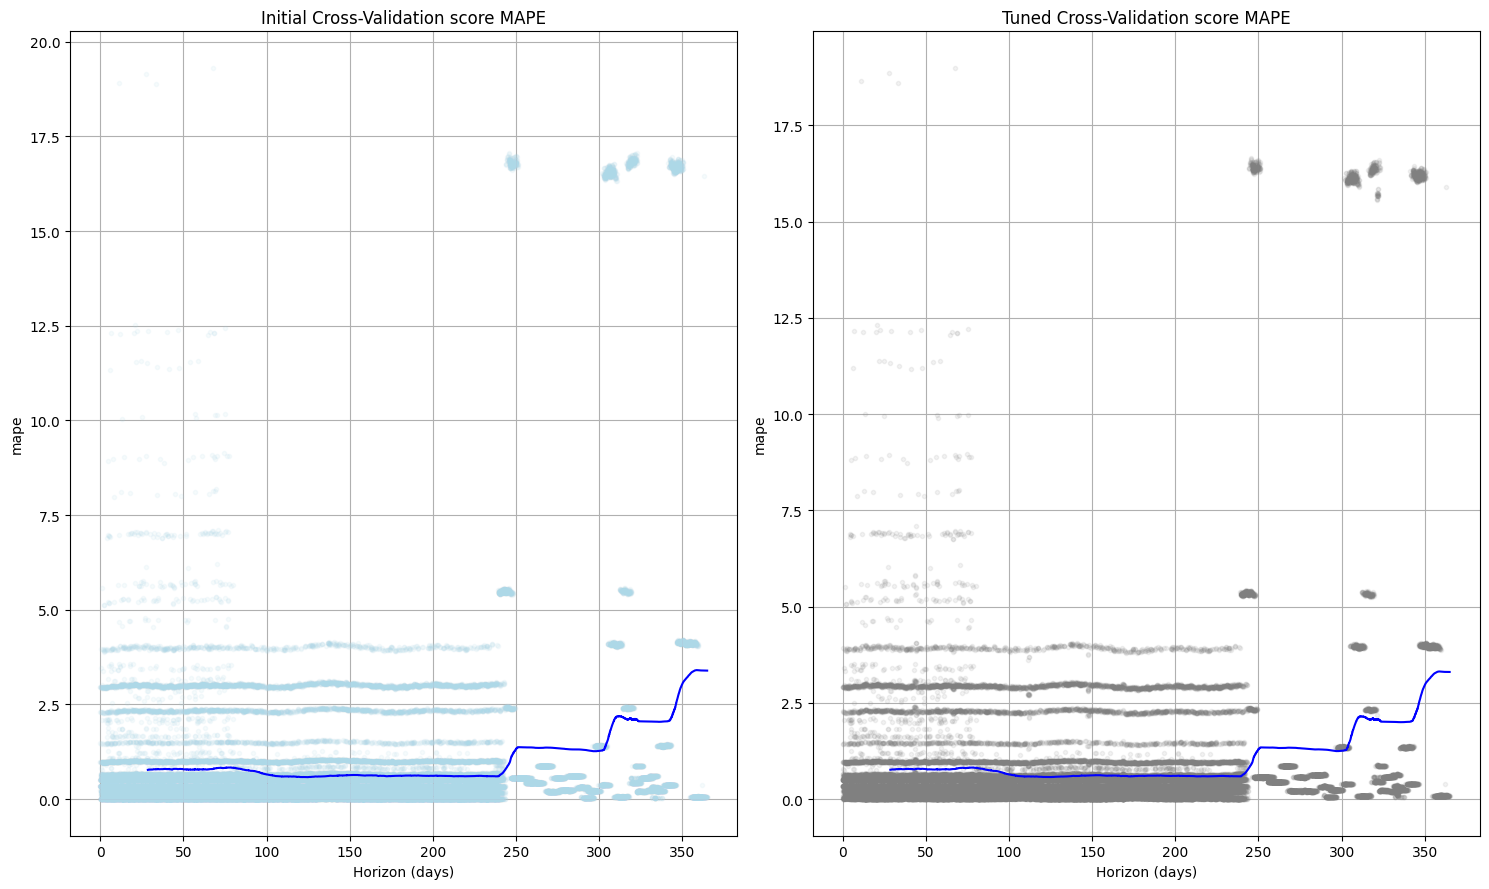

In [30]:
#| code-fold: true
#| code-summary: "Show the code"
fig, axs = plt.subplots(1, 2, figsize=(15, 9))

# Plot the first cross-validation metric
fig1 = plot_cross_validation_metric(df_cv, metric='mape', ax=axs[0])
fig1.get_axes()[0].get_lines()[0].set_markerfacecolor('#ADD8E7')  # Change color of the dots
fig1.get_axes()[0].get_lines()[0].set_markeredgecolor('#ADD8E7')  # Change color of the dot edges
# add title
axs[0].set_title('Initial Cross-Validation score MAPE')

# Plot the second cross-validation metric
fig2 = plot_cross_validation_metric(tuned_df_cv, metric='mape', ax=axs[1])
fig2.get_axes()[0].get_lines()[0].set_markerfacecolor('#ADD8E7')  # Change color of the dots
fig2.get_axes()[0].get_lines()[0].set_markeredgecolor('#ADD8E9')  # Change color of the dot edges
# add title
axs[1].set_title('Tuned Cross-Validation score MAPE')

plt.tight_layout()
plt.show()

<p>Not Exactly the outcome I was expecting but the tuned model’s performance remains consistent with the previous model. This may suggest that the model is not sensitive to the hyperparameters. Nonetheless, the model is still useful for forecasting demand for the top-selling product.</p>

In [31]:
forecast.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-03 00:00:00,171.739940,65.958081,385.890394,171.739940,171.739940,0.0,0.0,0.0,0.0,...,-0.913420,-0.913420,-0.913420,45.280427,45.280427,45.280427,0.0,0.0,0.0,215.005767
1,2015-01-03 03:30:00,171.959875,52.756509,369.108180,171.959875,171.959875,0.0,0.0,0.0,0.0,...,-1.108421,-1.108421,-1.108421,45.065329,45.065329,45.065329,0.0,0.0,0.0,215.523672


<h4 class="anchored">
Visualizing Forecasted Sales
</h4>

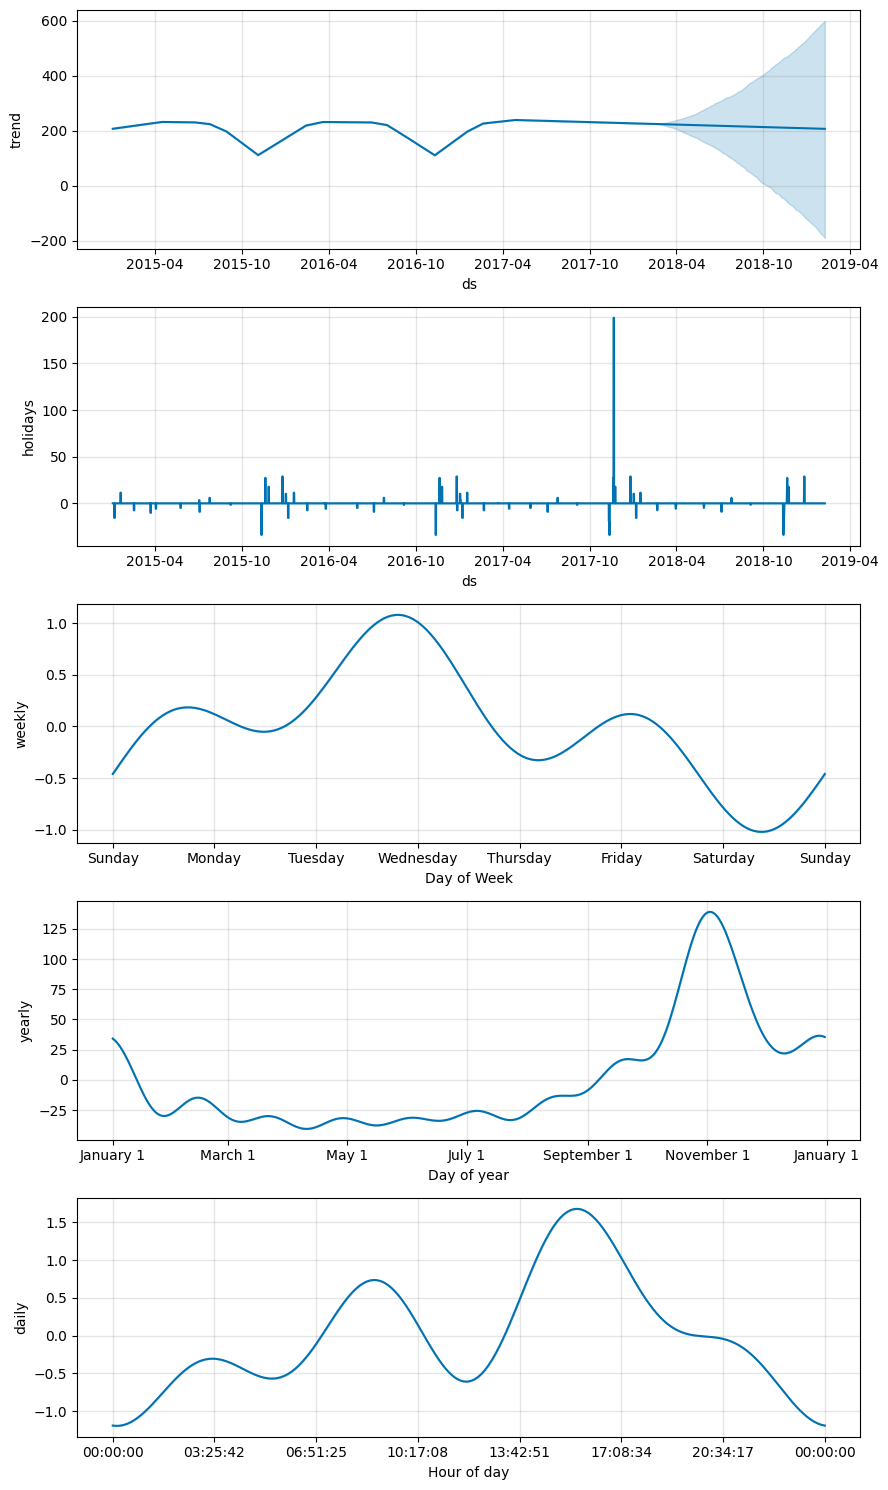

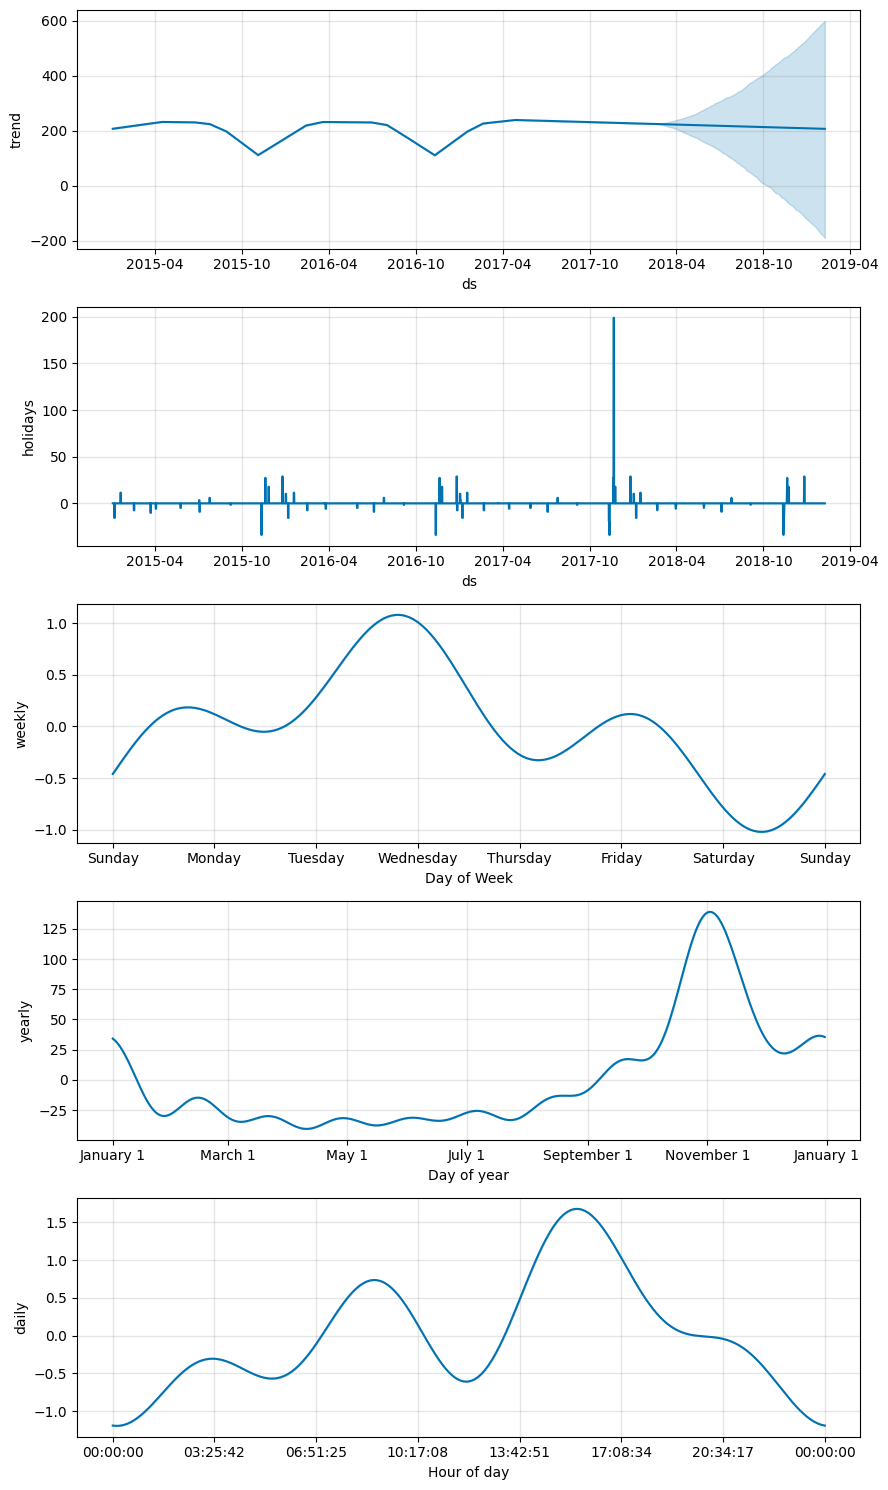

In [32]:
import warnings

# Ignore the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# Plot the forecast
tuned_prophet.plot_components(new_forecast)

<h1 class="anchored">
 Business Question #1
</h1>



><em><h5>What is the demand forecast for the top selling product in the next 24 months?</h5></em>



<p>
<p>The sales trend between <code>2015</code> and <code>2017</code> marks a cycle where sales for the product remained relatively stable during the second and third quarters of each year and then dipped slightly in October with a sharp increase between November and December.
</p>
<p>The forecasted sales for the next 24 months, on the other hand, indicate a very stable demand pattern.
<p>
The zero variance observed in the product price may account for the relatively stable sales pattern forecasted for `2018` and `2019`. It might also be worth investigating the factors that may account for the cyclical dips between 2015 and 2017
</p>
<p>
We can also observe the impact of the Puerto Rican holidays on the forecasted sales.
</p>
<h1 class="anchored">
Finding Optimal Inventory Policy Based on Forecasted Demand
</h1>
<p>
Now that we have forecasted the demand for the top-selling product, we can use the forecasted demand to calculate the optimal inventory policy for the product.</p>
<p>
Finding the optimal inventory policy will help us determine the <a href= "https://cashflowinventory.com/blog/reorder-point">Reorder Point</a>, <a href="https://cashflowinventory.com/blog/reorder-point">safety stock</a>, and <a href="https://cashflowinventory.com/blog/reorder-point" >Economic Order Quantity</a>(EOQ) for the product. These markers will help us ensure that we have the right amount of inventory on hand to meet customer demand while minimizing inventory costs.
</p>

<h2>Re Order Point</h2>
The reorder point is the inventory level at which we should reorder more stock.
`ROP`  is calculated as the product of the average sales per day and the lead time (also referred to as `Lead Time Demand`) plus the `Safety stock`.

$$ Reorder\ Point = \text{Lead\ Time\ Demand} + \text{Safety\ Stock} $$


let's Find the Lead Time Demand

$$ \text{Lead Time Demand} = \text{Average Sales Per Day} \times \text{Lead Time} $$

:::{.callout .note}

<p> <strong>NOTE:</strong> It is important to state the difference between the downstream and upstream lead time.</p>
<p>The `Lead Time` with regards to the reordering point is the time it takes for a product to be delivered by upstream supply chain manufacturers to the store's warehouse. It is the time between the placement of an order by the store and the receipt of the product.</p>
<p> The current dataset only provides the `Days for shipment (scheduled)` and the `Days for shipping (real)` which only helps us determine downstream lead times. The downstream lead time is the time it takes for a product to be delivered to the customer after it has been ordered. This is not the lead time we need to calculate the reorder point.</p>

:::



<p>For the purposes of our analysis we will assume an average upstream `Lead time` of 7 days </p>

In [33]:

# Extract average forecasted sales per day
average_forecasted_sales = new_forecast['yhat'].mean()


# Extract the average lead time
average_lead_time = 7  # 7 days
print(f"Average Lead Time: {average_lead_time}")

lead_time_demand = average_forecasted_sales * average_lead_time
print(f"Lead Time Demand: {lead_time_demand}")

Average Lead Time: 7
Lead Time Demand: 1469.3708593611893


<p>One final piece to the Reorder Point puzzle is the ` Safety Stock`. The safety stock is the extra stock that is kept on hand to mitigate the risk of stockouts due to uncertainties in demand and lead time.</p>

$$ \text{Safety Stock} = (\text{Maximum Daily Sales} \times \text{Maximum Lead Time}) - \text{Lead Time Demand}$$


<p>Let's also assume that there have been delays from the manufacturer in the past and the maximum lead time is 10 days. That is Three days later than the average order fulfillment timeline</p>

In [35]:
# find maximum daily forecasted sales
max_daily_forecasted_sales = new_forecast['yhat'].max()
print(f"Maximum Daily Forecasted Sales: {max_daily_forecasted_sales}")

# find maximum lead time
max_lead_time = average_lead_time + 3  # 3 days delays in delivery than the average
print(f"Maximum Lead Time: {max_lead_time}")

# calculate safety stock
safety_stock = (max_daily_forecasted_sales * max_lead_time) - lead_time_demand
print(f"Safety Stock: {safety_stock}")

Maximum Daily Forecasted Sales: 503.54806336319996
Maximum Lead Time: 10
Safety Stock: 3566.1097742708107


<p>Finally, we can calculate the reorder point for the top-selling product.</p>

<h3>Putting It All Together</h3>

In [36]:
# calculate reorder point
reorder_point = lead_time_demand + safety_stock
print(f"The Optimal Reorder Point for the Top-selling Product is: {reorder_point}")

The Optimal Reorder Point for the Top-selling Product is: 5035.480633632


<p> As indicated by the result, the reorder point for the top-selling product is `3753` units, which means that we should reorder more stock when the inventory level reaches `3753` units. This will help us ensure that we have enough stock on hand to meet customer demand while minimizing inventory costs.</p>

<h3>Economic Order Quantity (EOQ)</h3>
<p> Alternatively, we can use the <a href="https://dclcorp.com/blog/inventory/economic-order-quantity-eoq/">Economic Order Quantity (EOQ) model</a> to calculate the optimal order quantity for the top-selling product. The EOQ model helps us determine the optimal order quantity that minimizes the total inventory costs.</p>

<p>Unlike the Reorder Point which is concerned with determining the level of inventory at which a new order should be placed to avoid stockouts, EOQ takes into account the costs of ordering (e.g., setup costs) and the costs, of holding inventory (e.g., storage costs, opportunity costs).</p>



<p>The Economic Order Quantity (EOQ) formula is given by:</p>

$$ EOQ = \sqrt{\frac{2DS}{H}} $$

<p>Where:</p>

- \( D \) is the demand rate (number of units demanded),
- \( S \) is the ordering cost per order,
- \( H \) is the holding cost per unit per year.

<p>This formula helps in determining the optimal order quantity that minimizes the total inventory costs.</p>


:::{.callout .note}
**NOTE**: We can figure out the demand rate \( D \) based on the existing data. However, the ordering cost \( S \)  and holding cost \( H \)  are not provided in the dataset. For our analysis, We will assume that the ordering and holding cost is `10%` and `30%` of the product price respectively.

:::


<h4>Estimating Holding Cost and Ordering Cost</h4>
<h5>Holding Cost</h5>
<p>Holding costs typically include expenses related to storing inventory, such as warehousing, insurance, and security. It also includes the opportunity cost of tying up capital in inventory.</p>

<h5>Ordering Cost</h5>
<p>Ordering costs are the expenses incurred in the process of ordering and receiving inventory. This includes the cost of preparing and processing purchase orders, receiving and inspecting the goods, and storing and managing the inventory.</p>

In [37]:
# extract the product price of top selling product(product card id:365)
product_price = df[df['Product Card Id'] == 365]['Product Price'].iloc[0]
print(f"The Product Price is: {product_price}")
# calculate holding cost
H = 0.10 * product_price
# calculate ordering cost
S = 0.30 * product_price

# calculate forecasted demand rate
D = new_forecast['yhat'].mean()

print(f"The Demand Rate is: {D}")
print(f"The Holding Cost is: {H}")
print(f"The Ordering Cost is: {S}")

The Product Price is: 59.99000168
The Demand Rate is: 209.91012276588418
The Holding Cost is: 5.999000168
The Ordering Cost is: 17.997000504


<h4>Putting It All Together</h4>

In [38]:
EOQ = math.sqrt((2 * D * S) / H)
print(f"The Economic Order Quantity is: {EOQ}")

The Economic Order Quantity is: 35.48888187299376


<p>Based on the EOQ model, the optimal order quantity for the top-selling product is `35` units. This means that we should order `35` units of the product at a time to minimize the total inventory costs. This will help us ensure that we have the right amount of inventory on hand to meet customer demand while minimizing inventory costs.</p>

<h1 class="anchored">
 Business Question #2
</h1>

See Angry Jack(from spongebob) being angry about his Massive inventory buildup. soon we will see how he could use our new inventory optimisations.

><em><h5>What is the optimal inventory level for the top selling product?</h5></em>

<div class="card">
<p>The optimal inventory policy for the top-selling product is as follows:</p>

- **Reorder Point**: 3753 units
- **Economic Order Quantity (EOQ)**: 35 units
- **Safety Stock**: 2284 units

<p>Here's what Angry Jack should do:
</p>
<p>When the stock level of the top-selling product hits 3753 units, He needs to place an order of 35 units with his suppliers.</p>
<p>Inventory management decisions based on these markers will help the company ensure that there is the right amount of inventory of the top-selling product on hand to meet customer demand while minimizing inventory costs.</p>
</div>

<h1>Bonus: Investigating the Top Predictors of Demand Outcomes</h1>
<p>Now that we have forecasted the demand for the top-selling product and calculated the optimal inventory policy, we can investigate the top predictors of demand outcomes. This will help us understand the factors that contribute to demand patterns and identify opportunities to improve sales outcomes.</p>

<p>The top-selling product price has remained fixed throughout the dataset. We can safely rule out the product price as a predictor of demand outcome for the period under review.</p>

<h3>Wait....I have a Hypothesis</h3>
<p>I have a hunch that `Product Lead Time`, `Customer Segment` and some `Geographic factors` will be top predictors of demand outcomes.</p>
<p>I will test this hypothesis by conducting a feature importance analysis using the <a href="https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/">Random Forest</a> algorithm.</p>

<h5><em>Let's Investigate.....</em></h5>

<h4>Correlation Analysis</h4>
<p>Before we proceed with the feature importance analysis, let’s conduct a correlation analysis to identify the top predictors of demand outcomes.</p>

<p>
we will create the <a href="https://builtin.com/data-science/correlation-matrix#:~:text=A%20correlation%20matrix%20is%20a,1%20a%20not%20strong%20relationship.">correlation matrix</a> using the `corr()` method and then use the `heatmap()` function from the `seaborn` library to visualize the correlation matrix.</p>
<p>We will use the `label_encode_df` data frame created during the data preprocessing stage.</p>



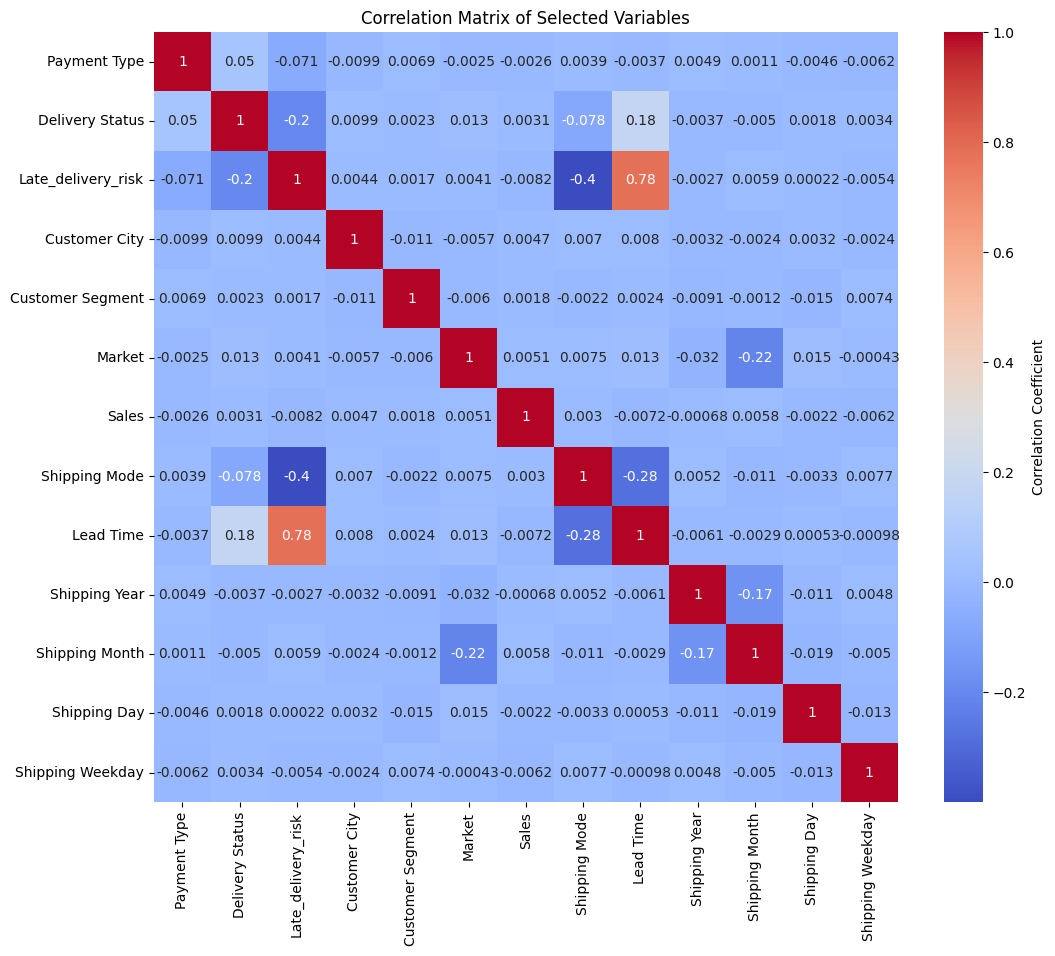

In [39]:
# correlation analysis
correlation_matrix = label_encode_df.corr()

# plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Selected Variables')
plt.show()

<h5>Observation</h5>
<p>The Heatmap shows there are no strong correlations between the features and the target variable. This suggests that the demand for the top-selling product is not strongly influenced by any single feature.</p>

<h4>Feature Importance Analysis Using Random Forest Regressor Model</h4>
<p>The correlation matrix could not identify the top predictors of demand outcomes. We will use the Random Forest algorithm to identify the top predictors of demand outcomes. The Random Forest algorithm is an ensemble learning method that uses multiple decision trees to make predictions. It is a powerful algorithm for feature importance analysis.</p>
<p> We will train a Random Forest Regressor model on the `onehot_encode_df` data frame and then use the `feature_importances_` attribute of the model to identify the top predictors of demand outcomes.</p>

<h5>Split the Data for Model Training</h5>

In [40]:
#| code-fold: true
#| code-summary: "Show the code"

from sklearn.model_selection import train_test_split

# prepare features excluding the sale
X_features = onehot_encode_df.drop(columns=['Sales'])
#  Drop Shipping year
X_features = X_features.drop(columns=['Shipping Year'])
# prepare target variable
y_target = onehot_encode_df['Sales']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42)


<h5>Train the Random Forest Regressor Model</h5>

In [41]:
#| code-fold: true
#| code-summary: "Show the code"

from sklearn.ensemble import RandomForestRegressor

# create a random forest regressor model
rf_model = RandomForestRegressor(n_estimators=150, max_depth=10,  min_samples_split=2)

# fit rf odel to the training data
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=150)

<h3>Feature Importance Analysis</h3>

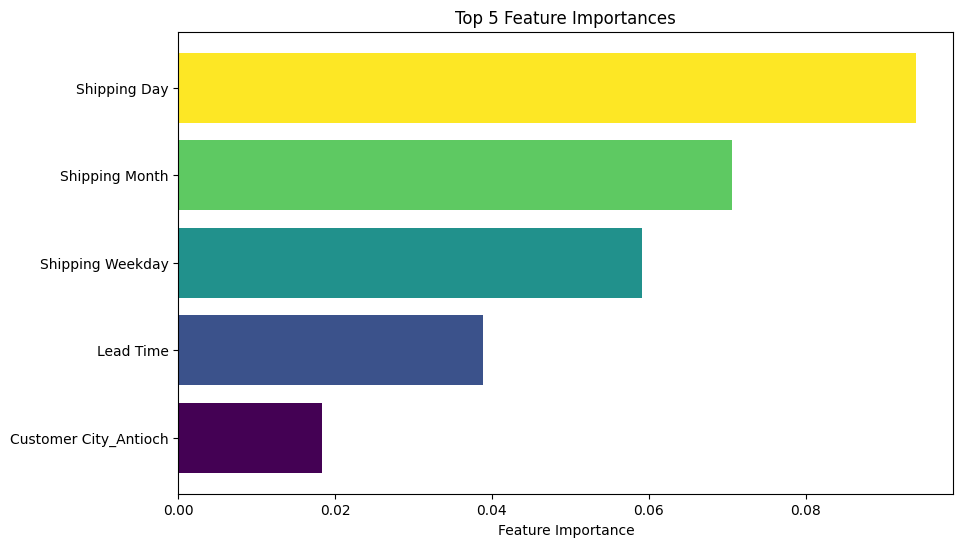

In [42]:
#| code-fold: true
#| code-summary: "Show the code"
import matplotlib.cm as cm
# retrieve the feature importances
feature_importances = rf_model.feature_importances_

# get the top 5 feature importances
top_5_feature_importances = feature_importances.argsort()[-5:]

# visualize the top 5 features of importance
plt.figure(figsize=(10, 6))
colors = cm.viridis(np.linspace(0, 1,
                                len(top_5_feature_importances)))
plt.barh(X_train.columns[top_5_feature_importances],
         feature_importances[top_5_feature_importances],
          color=colors)
plt.xlabel('Feature Importance')

plt.title('Top 5 Feature Importances')
plt.show()


<h4>Discussion of Results</h4>

<p>The feature importance analysis confirms the majority of my hypothesis</p>
<p>We can see that Product `Lead Time`, and some `Geographic factors` were among the top predictors of demand outcomes</p>
<p>`Customer Segment` however was not among the top predictors of demand outcomes. This brings us to the end of our analysis</p>

<h1>Key Takeaways</h1>
<p>If you made it this far, I hope you have enjoyed the journey. Here are the key takeaways from this project:</p>

- [x] We explored how to build a demand forecasting model with Python.
- [x] We used the model for inventory optimization, covering concepts like reorder points, safety stock, and economic order quantity (EOQ).
- [x] We discovered trends, seasonalities and holiday effects on the top-selling product based on the dataset provided.
- [x] We found the optimal inventory policy for the top-selling product.

<h4>How does this method offer enhanced scalability compared to conventional demand forecasting techniques?</h4>

<ol><li>The existing data processing steps can easily be adapted to accommodate larger product categories.
<li>Improved speed and accuracy.</li>
<li>Minimized guesswork and enhanced reproducibility for validating forecasts.</li>
</ol>
<p>Feel free to share your thoughts and feedback on my approach. I am open to learning and improving my skills.</p>